# Brand Sentiment Analysis of Twitter Posts

## Setup

### Package Management

We define a list of required packages and a function for installing them. This function, `handle_packages`, checks for each package in the system. If a package is not found, it is installed quietly using the pip package manager. 

By invoking `handle_packages` with the list of required packages, we make sure all project dependencies are satisfied, setting up a reliable and reproducible environment for our project.

In [1]:
import os

# INSTALL REQUIRED PACKAGES FOR PROJECT
PACKAGES = [
    "adjustText",
    "colorama",
    "dotenv",
    "gensim",
    "ipython",
    "ipywidgets",
    "joblib",
    "matplotlib",
    "nltk",
    "numpy",
    "openai",
    "pandas",
    "preprocessor",
    "python-dotenv",
    "seaborn",
    "sklearn",
    "tqdm",
    "tweet-preprocessor",
    "wandb",
    "wordcloud",
]


def handle_packages(packages: list) -> None:
    """Quietly installs a package if it is not already installed.

    Args:
        packages (list): The list of packages to install.

    Raises:
        ImportError: If the package is not installed, install it.
    """
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            os.system(f"python3 -m pip install -q {package}")


handle_packages(PACKAGES)

In [57]:
import datetime
import glob
import itertools
import json
import logging
import multiprocessing
import os
import pickle
import re
import string
import time
import warnings
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from enum import Enum
from functools import wraps
from pprint import pprint
from queue import Queue
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from abc import ABC, abstractmethod

import dotenv
import ipywidgets as widgets
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import openai
import pandas as pd
import preprocessor
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from adjustText import adjust_text
from colorama import Fore, Style
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import TaggedDocument
from IPython.display import Markdown, clear_output, display, display_html
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from tqdm import tqdm
from wordcloud import WordCloud

import wandb

warnings.filterwarnings("ignore")

In [3]:
# CREATE FOLDERS
os.makedirs("report", exist_ok=True)
os.makedirs("logs", exist_ok=True)

In [4]:
def is_git_lfs_pointer(file_path):
    try:
        with open(file_path, "r") as file:
            contents = file.read()
        return "version https://git-lfs.github.com/spec/v1" in contents
    except UnicodeDecodeError:
        # This is not a text file, so it's not a Git LFS pointer
        return False


patterns = [
    "datasets/*",
    "cache/*",
    "*.mp4",
    "Final-Project-Team-2.mp4",
]

for pattern in patterns:
    files = glob.glob(pattern)
    for file in files:
        if is_git_lfs_pointer(file):
            os.system(f"git lfs pull --include={file}")

In [5]:
class Metrics:
    """
    A class to hold metrics for monitoring performance.

    This class is a singleton, meaning that there is only one instance of the class throughout the entire program.
    All functions decorated with @measure_time share the same Metrics object.

    Attributes:
        metrics (dict): A dictionary to store the metrics.
    """

    _instance = None

    def __new__(cls):
        """
        Overrides the default object creation method to implement the singleton pattern.

        Returns:
            Metrics: The singleton instance of the Metrics class.
        """
        if cls._instance is None:
            cls._instance = super(Metrics, cls).__new__(cls)
            cls._instance.metrics = {}
        return cls._instance

    def __init__(self):
        """Initializes the Metrics class with an empty dictionary."""
        self.metrics: dict[str, float] = {}

    def add_metric(self, key: str, value: float) -> None:
        """
        Adds a new metric to the dictionary or appends to an existing one.

        Args:
            key (str): The name of the metric.
            value (float): The value of the metric.
        """
        if key in self.metrics:
            self.metrics[key] += value
        else:
            self.metrics[key] = value

    def get_metrics(self) -> dict[str, float]:
        """
        Returns the dictionary of metrics.

        Returns:
            dict: The dictionary of metrics.
        """
        return self.metrics

    def __str__(self) -> str:
        """Returns a string representation of the metrics."""
        return "\n".join(f"{k}: {v}" for k, v in self.metrics.items())

    def __getitem__(self, key: str) -> float:
        """
        Returns the value of the metric with the given key.

        Args:
            key (str): The key of the metric.

        Returns:
            float: The value of the metric.
        """
        return self.metrics.get(key)

    def __setitem__(self, key: str, value: float) -> None:
        """
        Sets the value of the metric with the given key.

        Args:
            key (str): The key of the metric.
            value (float): The value of the metric.
        """
        self.metrics[key] = value

    def __len__(self) -> int:
        """
        Returns the number of metrics.

        Returns:
            int: The number of metrics.
        """
        return len(self.metrics)

    def __contains__(self, key: str) -> bool:
        """
        Checks if the metric with the given key exists.

        Args:
            key (str): The key of the metric.

        Returns:
            bool: True if the metric exists, False otherwise.
        """
        return key in self.metrics

    def clear_metrics(self) -> None:
        """Clears all the metrics."""
        self.metrics.clear()

    def remove_metric(self, key: str) -> None:
        """
        Removes the metric with the given key.

        Args:
            key (str): The key of the metric.
        """
        if key in self.metrics:
            del self.metrics[key]

    def update_metric(self, key: str, value: float) -> None:
        """
        Updates the value of the metric with the given key.

        Args:
            key (str): The key of the metric.
            value (float): The new value of the metric.
        """
        if key in self.metrics:
            self.metrics[key] = value

    def print_metrics(self) -> None:
        """Prints all the metrics in a nice format."""
        print("Metrics:")
        sorted_metrics = sorted(
            self.metrics.items(), key=lambda item: item[1], reverse=True
        )
        for key, value in sorted_metrics:
            print(f"  {key}: {value:.2f} seconds")
        print(f"Total time: {sum(self.metrics.values()):.2f} seconds")


def measure_time(run_name: str):
    """
    A decorator factory that measures the time taken by a function and logs it to the Metrics singleton.

    Args:
        run_name (str): The name of the run. This is used to differentiate metrics among different runs.

    Returns:
        Callable: The decorator that wraps the function with timing and logging.
    """

    def decorator(func: Callable[..., Any]) -> Callable[..., Any]:
        """
        The actual decorator that wraps the function with timing and logging.

        Args:
            func (Callable): The function to be timed and logged.

        Returns:
            Callable: The wrapped function.
        """

        def wrapper(*args, **kwargs):
            """
            The wrapper function that adds timing and logging to the original function.

            Args:
                *args: The positional arguments for the original function.
                **kwargs: The keyword arguments for the original function.

            Returns:
                The result of the original function.
            """
            # START TIMER
            start_time = time.time()
            # CALL FUNCTION
            result = func(*args, **kwargs)
            # CALCULATE ELAPSED TIME
            total_time = time.time() - start_time
            # LOG RESULT
            metrics.add_metric(f"{run_name}", total_time)
            print(f"{run_name}...{total_time:.2f} seconds")
            return result

        return wrapper

    return decorator


metrics = Metrics()

### Setting Up Data Analysis and Visualization Tools

We import data handling and visualization libraries and configure them for ideal display. These steps prepare our environment for efficient data analysis and visualization tasks.

In [6]:
# CONFIGURE
pd.set_option("display.max_colwidth", 80)

# SET MATPLOTLIB STYLE TO 'fivethirtyeight'
plt.style.use("fivethirtyeight")

### Loading Environment Variables

We load environment variables from a `.env` file using the `dotenv` package. This file has key-value pairs of environment variables, which are then added to the system's environment variables. This approach lets us manage sensitive information securely and consistently across different project stages.

In [7]:
# LOAD ENVIRONMENT VARIABLES
ENVIRONMENT = dotenv.dotenv_values()
for key in ENVIRONMENT:
    os.environ[key] = ENVIRONMENT[key]

## Exploratory Data Analysis (EDA)

### Retrieving and Preparing the Sentiment140 Dataset

The Sentiment140 dataset, available at <http://help.sentiment140.com/for-students>, is a collection of 1.6 million tweets with sentiment labels. 

It is used for discovering the sentiment of a brand, product, or topic on Twitter.

The dataset, provided as a CSV file with emoticons removed, includes tweet content and sentiment labels. We extract these parts and remap the sentiment labels for easier interpretation in future analyses.

The dataset has 6 fields:
1. `target` — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. `id` — the id of the tweet (2087)
1. `date` — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
1. `flag` — the query (lyx). If there is no query, then this value is NO_QUERY.
1. `user` — the user that tweeted (robotickilldozr)
1. `text` — the text of the tweet (Lyx is cool)

In [8]:
tweets_df = pd.read_csv(
    "datasets/training.1600000.processed.noemoticon.csv",
    encoding="ISO-8859-1",
    names=["sentiment", "ids", "date", "flag", "user", "tweet"],
    header=None,
)

# GET TWEETS AND SENTIMENT LABELS
tweets_df = tweets_df[["tweet", "sentiment"]]

# REMAP SENTIMENT LABELS TO 0 = negative, 1 = positive (instead of 0 = negative, 4 = positive)
tweets_df.sentiment = tweets_df.sentiment.replace(4, 1)

### Class Balance

We ensure class balance in our dataset by counting the number of positive and negative tweets. Class balance is important because the model is trained on an equal number of instances from each class, preventing bias towards a particular sentiment. 

We generate a bar plot showing the distribution of sentiments in the training dataset, which indicates whether models will be trained on a balanced set of samples.

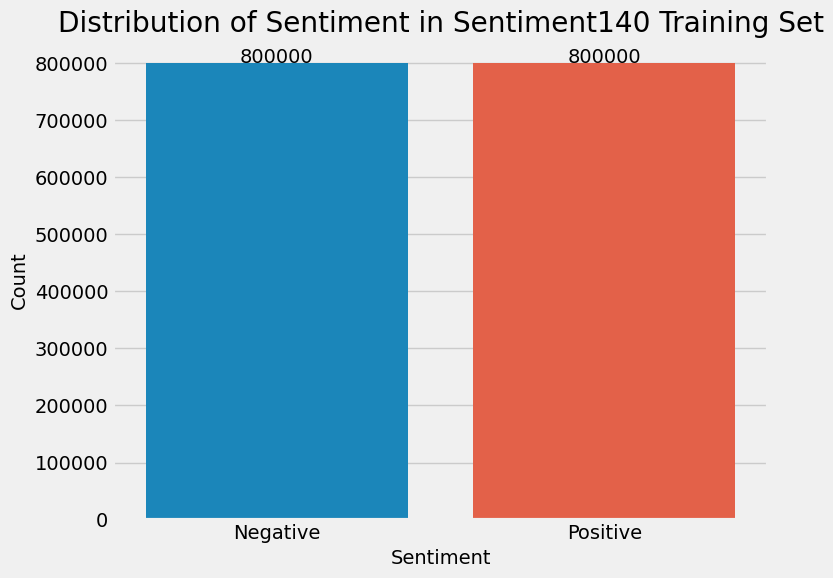

In [9]:
# SHOW SENTIMENT DISTRIBUTION IN TRAINING SET
distribution = tweets_df.sentiment.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title("Distribution of Sentiment in Sentiment140 Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])

for i, v in enumerate(distribution.values):
    # ADD COUNTS ABOVE BARS
    plt.text(i, v, str(v), ha="center")

# SAVE VISUALIZATION
plt.tight_layout()
plt.savefig("report/sentiment_distribution.png", dpi=300)

plt.show()

### Word Cloud

A word cloud is a visual representation where the most often occurring words are displayed larger than less common words. This visualization gives a quick understanding of the key themes or topics in the text data.

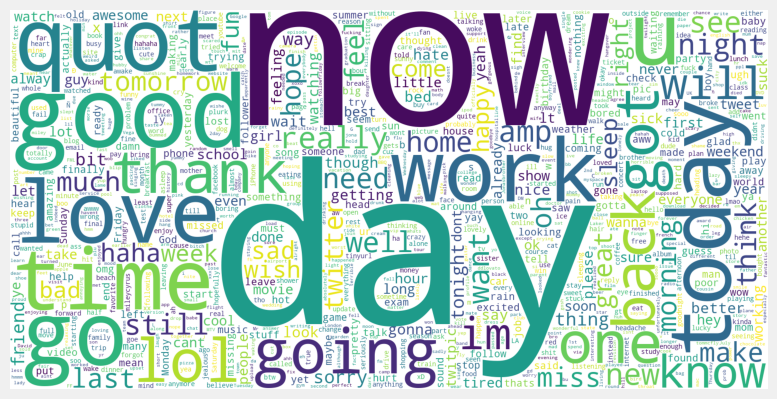

generating word cloud from training data...16.90 seconds


In [10]:
@measure_time("generating word cloud from training data")
def generate_wordcloud(df_train):
    """
    Generate a wordcloud from a dataframe.

    Args:
        df_train (DataFrame): The dataframe containing the text data.

    Returns:
        None
    """
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        min_font_size=10,
        max_words=1000,
        collocations=False,
        random_state=42,  # set for idempotency
    )

    wordcloud.generate(" ".join(df_train.tweet.tolist()))

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")

    # SAVE VISUALIZATION
    plt.tight_layout()
    plt.savefig("report/wordcloud.png", dpi=300)

    plt.show()


generate_wordcloud(tweets_df)

## Preprocessing

Preprocessing is a key step in Natural Language Processing (NLP) to improve the performance and accuracy of the models. The aim is to get the text data ready for machine learning algorithms. 

In its raw form, text data can be messy and unstructured, making it hard for a machine-learning model to understand and learn from. Preprocessing cleans up the data by removing unnecessary information like punctuation and common words that add little meaning or converting all text to lowercase so the model does not get confused by the same word in different cases. Transforming text into a clean and standardized form makes it easier for machine learning models to analyze the data and perform tasks like classification, prediction, or translation.

In [11]:
BRANDS = [
    "facebook",
    "google",
    "apple",
    "starbucks",
    "disney",
    "microsoft",
    "target",
    "amazon",
    "walmart",
    "sony",
]

In [12]:
# CALCULATE FREQUENCY OF EACH BRAND IN THE TWEETS
counter = Counter(
    word
    for tweet in tweets_df.tweet
    for word in tweet.lower().split()
    if word in BRANDS
)

# CREATE DATAFRAME FROM THE COUNTER
brand_freqs_df = pd.DataFrame(
    counter.items(), columns=["brand", "frequency"]
).sort_values("frequency", ascending=False)

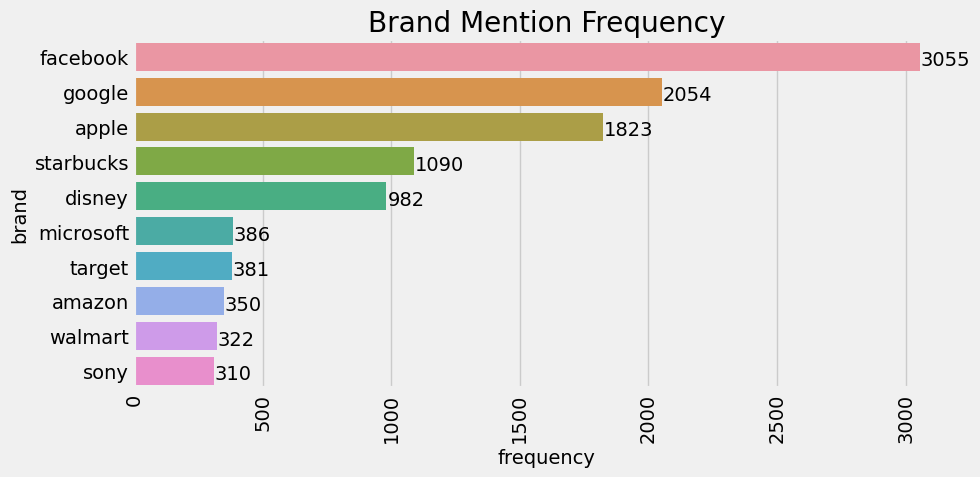

In [13]:
# VISUALIZE BRAND MENTION FREQUENCY

# CREATE BARPLOT
num_brands = len(brand_freqs_df)
plt.figure(figsize=(10, num_brands * 0.5))
barplot = sns.barplot(
    x="frequency", y="brand", data=brand_freqs_df, order=brand_freqs_df.brand
)
plt.xticks(rotation=90)
plt.title("Brand Mention Frequency")

# ADD COUNTS AT THE END OF THE BARS
for i, v in enumerate(brand_freqs_df.frequency):
    barplot.text(v + 3, i + 0.25, str(v))

# SAVE VISUALIZATION
plt.tight_layout()
barplot.figure.savefig("report/brand_mention_frequency.png", dpi=300)

plt.show()

### Process Tweets to Identify Brand Mentions

We analyze tweets and identify mentions of specific brands. The process begins by standardizing the text in each tweet, which aids in detecting brand names. Each tweet is analyzed for brand mentions. When a brand is detected, we store the original tweet text, a flag indicating a brand mention, and the brand name itself. Where no brand is mentioned, we record the brand name as `nobrand`.

In [14]:
@measure_time("creating brands dataframe")
def create_brand_dataframe(tweets_df: pd.DataFrame, brands: List[str]) -> pd.DataFrame:
    """
    Create a new dataframe with brand labels.

    Args:
        tweets_df (pd.DataFrame): The dataframe containing tweets and sentiments.
        brands (List[str]): The list of brands to be searched in the tweets.

    Returns:
        pd.DataFrame: The new dataframe with brand labels.
    """
    brand_rows = []
    non_brand_counter = 0
    brand_counter = 0
    for tweet, sentiment in zip(tweets_df.tweet, tweets_df.sentiment):
        tweet_tokens = tweet.lower().split()
        brand_found = False

        # Check if any words in the tweet are brands
        for word in tweet_tokens:
            word = word.replace("-", "")
            for brand in BRANDS:
                # If a brand is found, tag this tweet with the brand name
                if word == brand:
                    brand_rows.append(
                        {"tweet": tweet, "brand": brand, "sentiment": sentiment}
                    )
                    brand_found = True
                    brand_counter += 1
                    break

            # If a brand was already found in this tweet, move on to the next tweet
            if brand_found:
                break
        
        # For every brand tweet added, also add a row with no brand for balance
        if not brand_found and non_brand_counter < brand_counter:
            brand_rows.append(
                {"tweet": tweet, "brand": "nobrand", "sentiment": sentiment}
            )
            non_brand_counter += 1

    # Create new dataframe with the labeled brand data
    brands_df = pd.DataFrame(brand_rows, columns=["tweet", "brand", "sentiment"])
    return brands_df


brands_df = create_brand_dataframe(tweets_df, BRANDS)
display(brands_df.head())

creating brands dataframe...5.58 seconds


,tweet,brand,sentiment
0,is upset that he can't update his Facebook by texting it... and might cry as...,facebook,0
1,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,nobrand,0
2,amazon s3 plugin not worked in my website . it need PHP 5 . but my hosting p...,amazon,0
3,"Argh! I was suuuper sleepy an hour ago, now I'm wide awake. Hope I don't st...",nobrand,0
4,Nasty budget due and my iphone is being sent to Apple today.,apple,0


### Data Generation Using OpenAI's GPT-4 Model

We define parameters for data generation using OpenAI's GPT-4 model. The parameters include the model name, the desired dataset size, and a user prompt that outlines the required data format.

The data format is: 

"tweet"|||brand-presence|||brand

Here, 'tweet' represents a Twitter post, 'brand-presence' is a binary indicator (0 or 1) denoting the presence or absence of a brand in the tweet, and 'brand' is the name of a brand from a predefined list or 'nobrand' when no brand is mentioned in the tweet.

The user prompt also includes examples to guide the data generation process and specifies that the dataset should have an equal number of tweets with and without brand mentions.

We use OpenAI's API to generate the data. The API key is retrieved from the environment variables, and a chat completion task is created using the GPT-4 model and the defined user prompt. The generated data is then extracted from the chat completion response.

In [15]:
logging.basicConfig(filename="logs/data_generator.log", level=logging.INFO)


class Status(Enum):
    NOT_STARTED = "NOT_STARTED"
    QUEUED = "QUEUED"
    BALANCING = "BALANCING"
    BALANCED = "BALANCED"


class JobAction(Enum):
    GENERATE = "GENERATE"


class Job:
    def __init__(self, brand: str, sentiment: str, action: JobAction, count: int):
        """
        Initialize a Job object.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            action (JobAction): The action to be performed.
            count (int): The count of the action.
        """
        self.brand = brand
        self.sentiment = sentiment
        self.action = action
        self.count = count

    def __str__(self):
        return f"Job(brand={self.brand}, sentiment={self.sentiment}, action={self.action}, count={self.count})"


class DataGenerator:
    def __init__(
        self,
        brands: List[str],
        model: str = "gpt-4",
        samples_per_brand: int = 100,
        cache_file: str = "cache/generated_data.pkl",
    ):
        """
        Initialize a DataGenerator object.

        Args:
            brands (List[str]): The list of brands.
            model (str, optional): The model to be used. Defaults to "gpt-4".
            samples_per_brand (int, optional): The number of samples per brand. Defaults to 100.
            cache_file (str, optional): The cache file to be used. Defaults to "cache/generated_data.pkl".
        """
        logging.info("Initializing DataGenerator")
        self.brands = brands
        self.model = model
        self.samples_per_brand = samples_per_brand
        self.dataset_size = samples_per_brand * (len(brands) * 2 + 1)
        self.dataset = []
        self.seen_data = set()
        self.brand_counts = {brand: {"positive": 0, "negative": 0} for brand in brands}
        self.brand_status = {brand: Status.NOT_STARTED for brand in brands}
        openai.api_key = os.environ["OPENAI_API_KEY"]
        self.cache_file = cache_file
        self.load_or_initialize_dataset()
        self.delete_excess_data()
        self.job_list = []

    def add_job(self, brand: str, sentiment: str, action: JobAction):
        """
        Add a job to the job list.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            action (JobAction): The action to be performed.
        """
        count = self.calculate_job_count(brand, sentiment, action.value.lower())
        job = Job(brand, sentiment, action, count)
        self.job_list.append(job)
        logging.info(f"Job added: {job}")

    def calculate_jobs(self):
        """
        Calculate the jobs to be performed.
        """
        logging.info("Calculating jobs")
        for brand in self.brands:
            for sentiment in ["positive", "negative"]:
                current_count = self.brand_counts[brand][sentiment]
                target_count = self.get_target_count(brand)
                if (
                    current_count < target_count
                    and self.brand_status[brand] != Status.BALANCED
                ):
                    self.add_job(brand, sentiment, JobAction.GENERATE)
                elif (
                    current_count > target_count
                    and self.brand_status[brand] != Status.BALANCED
                ):
                    self.delete_excess_data()
        self.report_metrics()

    def process_jobs(self):
        """
        Process the jobs in the job list.
        """
        logging.info("Processing jobs")
        while self.job_list:
            job = self.job_list.pop(0)
            if self.brand_status[job.brand] != Status.BALANCED:
                self.process_job(job)

    def process_job(self, job: Job):
        """
        Process a job.

        Args:
            job (Job): The job to be processed.
        """
        logging.info(f"Processing job: {job}")
        self.update_status(job.brand, Status.BALANCING)
        if job.action == JobAction.GENERATE:
            self.generate_brand_data(job.brand, job.sentiment, job.count)
        self.delete_excess_data()
        self.update_status(job.brand, Status.BALANCED)
        self.report_metrics()

    def calculate_job_count(self, brand: str, sentiment: str, action: str) -> int:
        """
        Calculate the job count.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            action (str): The action to be performed.

        Returns:
            int: The job count.
        """
        logging.info(
            f"Calculating job count for brand: {brand}, sentiment: {sentiment}, action: {action}"
        )
        if action == JobAction.GENERATE:
            return self.get_target_count(brand) - self.brand_counts[brand][sentiment]

    def balance(self):
        """
        Generate a balanced dataset.
        """
        logging.info("Generating balanced dataset")
        self.calculate_jobs()
        self.process_jobs()

    def update_status(self, brand: str, status: Status):
        """
        Update the status of a brand.

        Args:
            brand (str): The brand name.
            status (Status): The status to be updated.
        """
        logging.info(f"Updating status for brand: {brand} to {status}")
        self.brand_status[brand] = status
        self.report_metrics()

    def generate_brand_data(self, brand: str, sentiment: str, count: int = None):
        """
        Generate data for a brand.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            count (int, optional): The count of the data to be generated. Defaults to None.
        """
        logging.info(f"Generating {sentiment} data for brand: {brand}")
        target_count = self.get_target_count(brand)
        while self.brand_counts[brand][sentiment] < target_count:
            remaining = target_count - self.brand_counts[brand][sentiment]
            self.generate_and_add_data_until_target(brand, sentiment, remaining)
            self.save_generated_data()
            self.report_metrics(brand)

    def get_target_count(self, brand: str) -> int:
        """
        Get the target count for a brand.

        Args:
            brand (str): The brand name.

        Returns:
            int: The target count.
        """
        return self.samples_per_brand // 2

    def generate_and_add_data_until_target(
        self, brand: str, sentiment: str, remaining: int
    ):
        """
        Generate and add data until the target count is reached.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            remaining (int): The remaining count to reach the target.
        """
        while remaining > 0:
            chunks = min(remaining, 50)
            user_prompt = self.create_prompt(brand, sentiment, chunks)
            self.generate_and_add_data(user_prompt, brand, sentiment, chunks)
            remaining = (
                self.get_target_count(brand) - self.brand_counts[brand][sentiment]
            )

    def generate_and_add_data(
        self,
        user_prompt: str,
        brand: str,
        sentiment: str,
        count: int,
        max_retries: int = 3,
    ):
        """
        Generate and add data to the dataset.

        Args:
            user_prompt (str): The user prompt.
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            count (int): The count of the data to be generated.
            max_retries (int, optional): The maximum number of retries. Defaults to 3.
        """
        logging.info(
            f"Generating and adding data for brand: {brand}, sentiment: {sentiment}"
        )
        retries = 0
        while retries < max_retries:
            data = self.generate_data_from_api(user_prompt, count)
            data = data.split("\n")
            valid_data = [item for item in data if len(item.split("|||")) >= 3]
            if len(valid_data) > 0:
                self.add_valid_data_to_dataset(valid_data, brand, sentiment)
                self.save_generated_data()
                break
            else:
                retries += 1
        if retries == max_retries:
            logging.error(
                f"Failed to generate valid data for {brand} after {max_retries} attempts."
            )
        self.report_metrics(brand)

    def add_valid_data_to_dataset(self, valid_data: list, brand: str, sentiment: str):
        """
        Add valid data to the dataset.

        Args:
            valid_data (list): The valid data to be added.
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
        """
        logging.info(
            f"Adding valid data to dataset for brand: {brand}, sentiment: {sentiment}"
        )
        for item in valid_data:
            if len(self.dataset) >= self.dataset_size:
                break
            item_parts = item.split("|||")
            item_brand = item_parts[1].lower()
            if item_brand not in self.brand_counts:
                continue
            item_sentiment = "positive" if item_parts[2] == "1" else "negative"
            item_parts[1] = item_brand
            item = "|||".join(item_parts)
            if item not in self.seen_data:
                self.dataset.append(item)
                self.seen_data.add(item)
                self.brand_counts[item_brand][sentiment] += 1

    def create_prompt(self, brand: str, sentiment: str, count: int) -> str:
        """
        Create a prompt.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            count (int): The count of the data to be generated.

        Returns:
            str: The created prompt.
        """
        logging.info(f"Creating prompt for brand: {brand}, sentiment: {sentiment}")
        if sentiment == "positive":
            return self.create_positive_prompt(brand, count)
        else:
            return self.create_negative_prompt(brand, count)

    def create_positive_prompt(self, brand: str, count: int) -> str:
        """
        Create a positive prompt.

        Args:
            brand (str): The brand name.
            count (int): The count of the data to be generated.

        Returns:
            str: The created prompt.
        """
        logging.info(f"Creating positive prompt for brand: {brand}")
        return f"""
            Create some random data that only mention the brand {brand} in the format: 
            "tweet"|||brand|||sentiment 
            where:
                tweet is a Twitter post, 
                brand is {brand}, and
                sentiment is 1 indicating positive sentiment of the tweet.

            EXAMPLES (with other brands)
                "My Taco Bell was great guys"|||taco bell|||1
                "Big thanks to our friends at Hattiesburg Coca-Cola for the banner celebrating R6's run to the national championship. We appreciate your support! Banner is on display in the Cook Union, stop by and see it!"|||coca cola|||1

            AIM: Try to come up with a diverse dataset of tweets that mention brand {brand} and are positive.

            Create {count} data points.
            """

    def create_negative_prompt(self, brand: str, count: int) -> str:
        """
        Create a negative prompt.

        Args:
            brand (str): The brand name.
            count (int): The count of the data to be generated.

        Returns:
            str: The created prompt.
        """
        logging.info(f"Creating negative prompt for brand: {brand}")
        return f"""
            Create some random data that only mention the brand {brand} in the format: 
            "tweet"|||brand|||sentiment 
            where
                tweet is a Twitter post, 
                brand is {brand}, and
                sentiment is 0 indicating negative sentiment of the tweet.

            EXAMPLES (with other brands)
                "It's taken me years, up to this moment, to realize my Gibson guitar sucks ass"|||gibson|||0
                "ppl at netflix are making a lot of really fucking dumb decisions like...way too often. like they got a bad idea assembly line just cranking out mistakes"|||netflix|||0

            AIM: Try to come up with a diverse dataset of tweets that mention the brand {brand} and are negative.

            Create {count} data points.
            """

    def generate_data_from_api(self, user_prompt: str, count: int) -> str:
        """
        Generate data from the API.

        Args:
            user_prompt (str): The user prompt.
            count (int): The count of the data to be generated.

        Returns:
            str: The generated data.
        """
        if count is None:
            count = 50
        logging.info(f"Generating data with prompt: {user_prompt}")
        wait_time = 5
        retries = 0
        while retries < 3:
            try:
                chat_completion = openai.ChatCompletion.create(
                    model=self.model,
                    temperature=0.4,
                    max_tokens=count * 50,
                    messages=[
                        {"role": "user", "content": user_prompt},
                    ],
                )
                return chat_completion.choices[0].message.content
            except openai.OpenAIError as e:
                if "Rate limit exceeded" in str(e) or "Bad Gateway" in str(e):
                    logging.error(
                        f"Error: {str(e)}. Retrying in {wait_time} seconds..."
                    )
                    print(f"Error: {str(e)}. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                    wait_time *= 2
                    retries += 1
                else:
                    logging.error(f"Unexpected error: {str(e)}")
                    raise e
        logging.error("Failed to generate data after 3 retries.")
        raise Exception("Failed to generate data after 3 retries.")

    def load_or_initialize_dataset(self):
        """
        Load or initialize the dataset.
        """
        logging.info("Loading or initializing dataset")
        if os.path.exists(self.cache_file):
            self.load_generated_data(self.cache_file)
        else:
            self.initialize_dataset()
            self.save_generated_data()

    def initialize_dataset(self):
        """
        Initialize the dataset.
        """
        logging.info("Initializing dataset")
        self.dataset = []
        self.seen_data = set()
        self.brand_counts = {
            brand: {"positive": 0, "negative": 0} for brand in self.brands
        }

    def save_generated_data(self):
        """
        Save the generated data.
        """
        logging.info("Saving generated data")
        with open(self.cache_file, "wb") as f:
            pickle.dump(self.dataset, f)

    def load_generated_data(self, filename: str):
        """
        Load the generated data.

        Args:
            filename (str): The filename of the data to be loaded.
        """
        logging.info(f"Loading generated data from file: {filename}")
        with open(filename, "rb") as f:
            loaded_data = pickle.load(f)
        if isinstance(loaded_data, list):
            self.dataset = [
                data
                for data in loaded_data
                if data.split("|||")[1].lower() in self.brand_counts
            ]
            self.update_counts()
        else:
            logging.error(
                "Loaded data is not in the expected format (list), initializing a new dataset."
            )
            self.initialize_dataset()

    def update_counts(self):
        """
        Update the counts of the data.
        """
        logging.info("Updating counts")
        for data in self.dataset:
            parts = data.split("|||")
            if len(parts) < 3:
                continue
            brand = parts[1].lower()
            sentiment = "positive" if parts[2] == "1" else "negative"
            if brand in self.brand_counts:
                self.brand_counts[brand][sentiment] += 1

    def report_metrics(self, last_updated_brand: str = None):
        """
        Report the metrics.

        Args:
            last_updated_brand (str, optional): The last updated brand. Defaults to None.
        """
        logging.info("Reporting metrics")
        clear_output(wait=True)

        brands = []
        positive_counts = []
        negative_counts = []
        status = []

        for brand in self.brand_counts.keys():
            brands.append(brand)
            positive_counts.append(
                f"{self.brand_counts[brand]['positive']}/{self.get_target_count(brand)}"
            )
            negative_counts.append(
                f"{self.brand_counts[brand]['negative']}/{self.get_target_count(brand)}"
            )
            status.append(self.get_status(brand))

        df_brands = pd.DataFrame(
            {
                "Brands": brands,
                "Positive Counts": positive_counts,
                "Negative Counts": negative_counts,
                "Status": status,
            }
        )

        df_jobs = pd.DataFrame(
            [
                (job.brand, job.sentiment, job.action.name, job.count)
                for job in self.job_list
            ],
            columns=["Brand", "Sentiment", "Action", "Count"],
        )

        df1_styler = df_brands.style.set_table_attributes(
            "style='display:inline; vertical-align:top'"
        ).set_caption("Brands")

        df2_styler = df_jobs.style.set_table_attributes(
            "style='display:inline; vertical-align:top'"
        ).set_caption("Jobs")

        display_html(
            df1_styler._repr_html_() + df2_styler._repr_html_(),
            raw=True,
        )

    def get_status(self, brand: str) -> str:
        """
        Get the status of a given brand.

        Args:
            brand (str): The brand name.

        Returns:
            str: The status of the brand.
        """
        logging.info(f"Getting status for brand: {brand}")
        if brand is None:
            return Status.NOT_STARTED
        else:
            target_count = self.get_target_count(brand)
            if (
                self.brand_counts[brand]["positive"] == target_count
                and self.brand_counts[brand]["negative"] == target_count
            ):
                return Status.BALANCED
            elif (
                self.brand_counts[brand]["positive"] > 0
                or self.brand_counts[brand]["negative"] > 0
            ):
                return Status.BALANCING
            else:
                return Status.QUEUED

    def delete_excess_data(self):
        """
        Delete excess data from the dataset.
        """
        logging.info("Deleting excess data")
        loop_counter = 0
        max_loops = 10000

        for brand in self.brands:
            for sentiment in ["positive", "negative"]:
                target_count = self.get_target_count(brand)
                while self.brand_counts[brand][sentiment] > target_count:
                    logging.info(
                        f"Deleting excess data for brand: {brand}, sentiment: {sentiment}"
                    )
                    found = False
                    for i in range(len(self.dataset) - 1, -1, -1):
                        parts = self.dataset[i].split("|||")
                        if len(parts) < 3:
                            continue
                        data_brand = parts[1]
                        data_sentiment = "positive" if parts[2] == "1" else "negative"
                        if data_brand == brand and data_sentiment == sentiment:
                            del self.dataset[i]
                            self.brand_counts[brand][sentiment] -= 1
                            found = True
                            break
                    if not found:
                        logging.error(
                            f"No matching data points found for brand: {brand}, sentiment: {sentiment}"
                        )
                        break
                    loop_counter += 1
                    if loop_counter >= max_loops:
                        logging.error("Reached maximum number of loops, breaking...")
                        break

In [16]:
data_generator = DataGenerator(BRANDS, samples_per_brand=400)
data_generator.balance()

,Brands,Positive Counts,Negative Counts,Status
0,facebook,200/200,200/200,Status.BALANCED
1,google,200/200,200/200,Status.BALANCED
2,apple,200/200,200/200,Status.BALANCED
3,starbucks,200/200,200/200,Status.BALANCED
4,disney,200/200,200/200,Status.BALANCED
5,microsoft,200/200,200/200,Status.BALANCED
6,target,200/200,200/200,Status.BALANCED
7,amazon,200/200,200/200,Status.BALANCED
8,walmart,200/200,200/200,Status.BALANCED
9,sony,200/200,200/200,Status.BALANCED


### Processing and Integrating Generated Data

The raw content generated by the GPT-4 model is processed by splitting it into three parts: 'tweet', 'brand-presence', and 'brand'. This is achieved by separating each line of the raw content on the delimiter '|||'. The processed content is then stored in a structured format as a list of dictionaries.

The processed content is converted into a pandas DataFrame and added to the existing `brands_df` DataFrame. This integration step ensures the newly generated data is combined with any current data for further analysis. Any missing values in the 'brand' column of the DataFrame are filled with 'nobrand'. This step ensures data consistency by providing a placeholder value for tweets where no brand is mentioned.

In [17]:
# Load the data
data_generator.load_generated_data("cache/generated_data.pkl")

# Convert the data into a DataFrame
data = [item.split("|||") for item in data_generator.dataset]
print(len(data))
generated_data = pd.DataFrame(data, columns=["tweet", "brand", "sentiment"])
print(generated_data.sentiment.value_counts())

4001
0    2001
1    2000
Name: sentiment, dtype: int64


In [18]:
# Be careful not to run this multiple times without resetting brands_df, it will add duplicate entries
brands_df = pd.concat([brands_df, generated_data], ignore_index=True)

In [19]:
print(f"brands_df.shape: {brands_df.shape}")

brands_df.shape: (25141, 3)


In [20]:
print(f"brands_df.brand.value_counts(): {brands_df.brand.value_counts()}")

brands_df.brand.value_counts(): nobrand      10570
facebook      3413
google        2370
apple         2170
starbucks     1477
disney        1359
walmart        799
target         774
microsoft      772
amazon         741
sony           696
Name: brand, dtype: int64


In [21]:
print(f"brands_df.tail(6): \n{brands_df.tail(6)}")

brands_df.tail(6): 
                                                                          tweet  \
25135             "Sony's speakers are the worst. The sound keeps cutting out."   
25136                  "I hate my Sony TV. The remote control is so confusing."   
25137      "Sony's headphones are so overpriced. They are not worth the money."   
25138                   "My Sony laptop is so slow. I can't get any work done."   
25139                       "Sony's camera is so bad. The focus is always off."   
25140  "The Sony gaming console is so bad. The controller keeps disconnecting."   

      brand sentiment  
25135  sony         0  
25136  sony         0  
25137  sony         0  
25138  sony         0  
25139  sony         0  
25140  sony         0  


In [22]:
# OUTPUT DATASET TO FILE
print(len(brands_df))
brands_df.to_csv("datasets/brands.csv", index=False)

25141


### Brand Mention Distribution Visualization

We create a visual representation of the distribution of brand mentions within a collection of tweets. We use a bar plot to illustrate the count of tweets mentioning a brand versus those not.

Brand       14571
No Brand    10570
Name: brand, dtype: int64


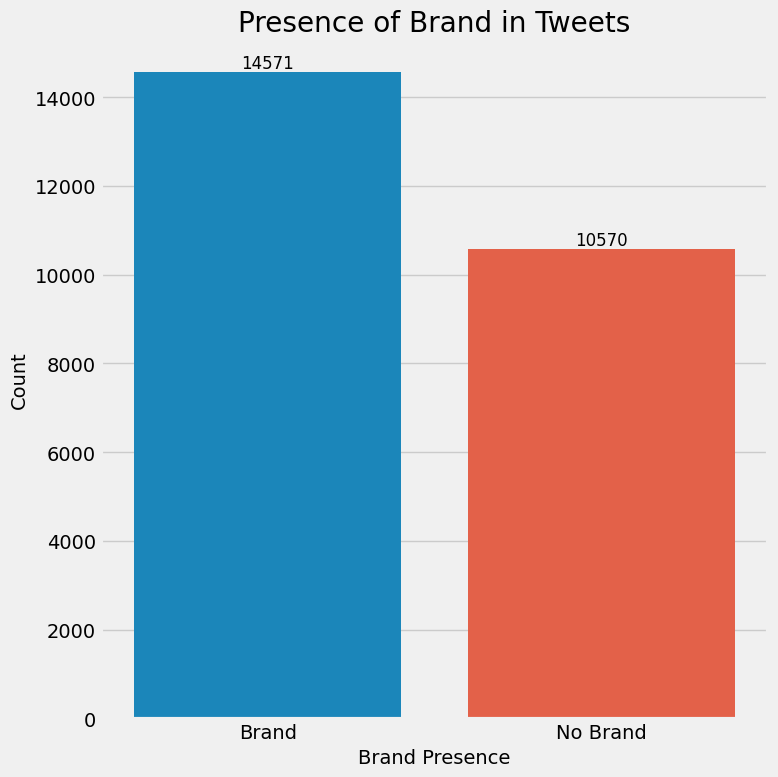

In [23]:
# Get counts of brand_presence
brand_presence = brands_df["brand"].apply(
    lambda x: "No Brand" if x == "nobrand" else "Brand"
)
print(brand_presence.value_counts())

counts = brand_presence.value_counts().reset_index()

# Plot counts of tweets with a brand and tweets with no brand
plt.figure(figsize=(8, 8))
ax = sns.barplot(x="index", y=brand_presence.name, data=counts)
plt.title("Presence of Brand in Tweets")
plt.ylabel("Count")
plt.xlabel("Brand Presence")


for p in ax.patches:
    # Add counts to bars
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize=12,
        color="black",
        ha="center",
        va="bottom",
    )

# Save visualization
plt.tight_layout()
plt.savefig("report/brand_count.png", dpi=300)

plt.show()

nobrand      10570
facebook      3413
google        2370
apple         2170
starbucks     1477
disney        1359
walmart        799
target         774
microsoft      772
amazon         741
sony           696
Name: brand, dtype: int64


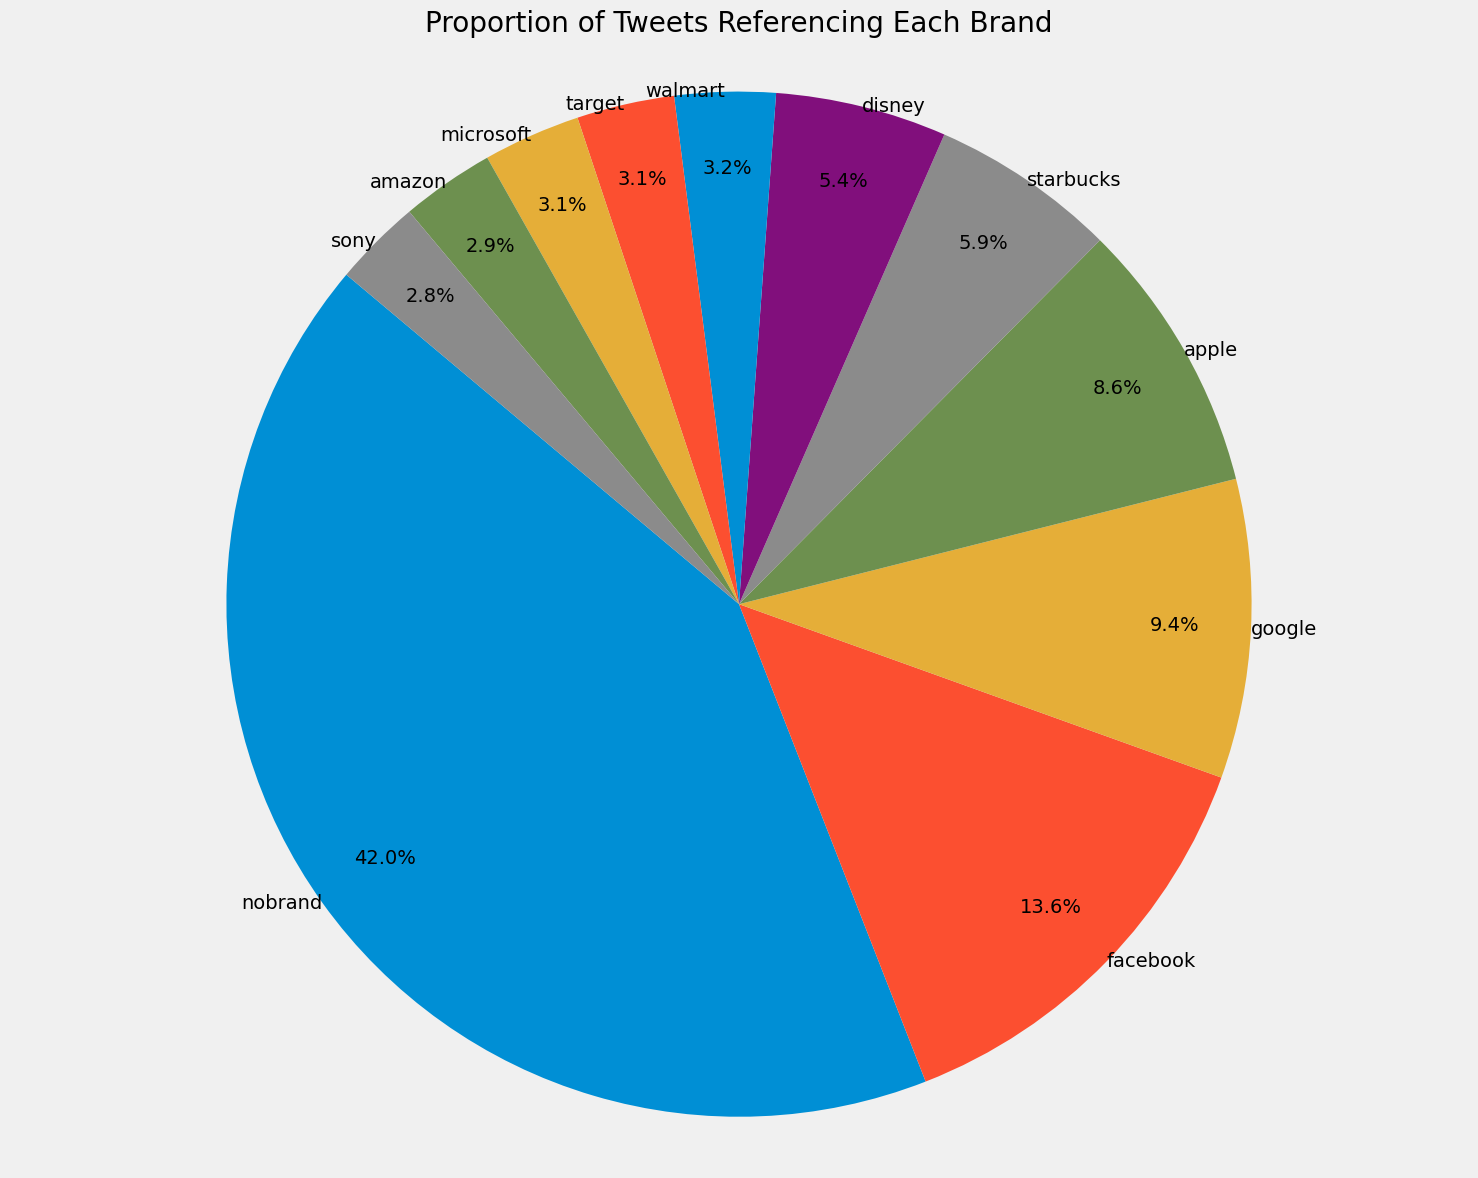

In [24]:
brand_counts = brands_df["brand"].value_counts()
print(brand_counts)

plt.figure(figsize=(15, 12))
plt.pie(
    brand_counts,
    labels=brand_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.85,
    labeldistance=1,
)
plt.axis("equal")
plt.title("Proportion of Tweets Referencing Each Brand")

# SAVE VISUALIZATION
plt.tight_layout()
plt.savefig("report/proportion_brands_in_tweets.png", dpi=300)

plt.show()

### Natural Language Toolkit (`nltk`) for Text Processing

We initialize the Natural Language Toolkit (`nltk`), a Python library for processing human language data. It offers tools for various tasks, including classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

Key parts from `nltk` are downloaded: a tokenizer, a part-of-speech tagger, a named entity chunker, a corpus of words, a multilingual lexical database, and a corpus of stopwords. 

The tokenizer helps break down the text into sentences or words, the part-of-speech tagger assigns parts of speech to individual words, and the named entity chunker identifies named entities within the text.

The corpus of words and the multilingual lexical database can be used for tasks such as spellchecking or language identification.

The stopwords corpus lists common words, known as "stop words", in several languages, including English. These words are often filtered out during text processing and rarely have significant meaning.

We generate a set of English stop words to expedite membership checking. This set will be used later in the text processing pipeline to filter out stop words from the text data.


In [25]:
# PUNKT TOKENIZER FOR SENTENCE TOKENIZATION
nltk.download("punkt", quiet=True)

# TAGGER FOR PART-OF-SPEECH TAGGING
nltk.download("averaged_perceptron_tagger", quiet=True)

# CHUNKER FOR NAMED ENTITY RECOGNITION
nltk.download("maxent_ne_chunker", quiet=True)

# CORPUS OF WORDS FOR SPELLCHECKING OR LANGUAGE IDENTIFICATION
nltk.download("words", quiet=True)

# MULTILINGUAL LEXICAL DATABASE
nltk.download("omw-1.4", quiet=True)

# DOWNLOAD STOPWORDS CORPUS
nltk.download("stopwords", quiet=True)

# CREATE SET OF ENGLISH STOPWORDS FOR FASTER MEMBERSHIP CHECKING
STOP_WORDS = set(stopwords.words("english"))

### Preprocessing Tweets for Text Analysis

We implement a preprocessing function to clean and standardize the text in tweets. This function removes URLs and @mentions, tokenizes the text into individual words, removes stopwords and punctuation, and applies stemming to reduce words to their root form. This preprocessing function is then applied to each tweet in the dataset. A sample of the original and preprocessed tweets is displayed to visually check the preprocessing results. This step ensures the preprocessing function works as expected and the tweets are ready for further text analysis.


In [26]:
# SET OPTIONS TO REMOVE URLS AND @MENTIONS
preprocessor.set_options(preprocessor.OPT.URL, preprocessor.OPT.MENTION)

# INITIALIZE STEMMER
STEMMER = SnowballStemmer("english")

# CONVERT STOPWORDS AND PUNCTUATION TO SETS
STOP_WORDS_SET = set(STOP_WORDS)
PUNCTUATION_SET = set(string.punctuation)


def preprocess(tweet: str) -> list:
    """
    Function to preprocess a tweet by removing URLs, @mentions, stopwords and punctuation.
    It also tokenizes and stems the tweet.

    Args:
        tweet (str): The tweet to be preprocessed.

    Returns:
        list: The preprocessed tweet as a list of stemmed tokens.
    """
    # CLEAN TWEET BY REMOVING URLS AND @MENTIONS
    cleaned = preprocessor.clean(tweet)
    # TOKENIZE TWEET INTO INDIVIDUAL WORDS
    tokens = re.findall(r"\b\w+\b", cleaned)
    # REMOVE STOPWORDS AND PUNCTUATION FROM TOKENS
    filtered = [
        word
        for word in tokens
        if word not in STOP_WORDS_SET and word not in PUNCTUATION_SET
    ]
    # APPLY STEMMING TO FILTERED TOKENS
    stemmed = [STEMMER.stem(word) for word in filtered]
    return stemmed


@measure_time("preprocessing training data")
def apply_preprocessing(df):
    """
    Function to apply preprocessing to each tweet in the DataFrame using multithreading.

    Args:
        df (DataFrame): The DataFrame containing the tweets.

    Returns:
        DataFrame: The DataFrame with the preprocessed tweets.
    """
    with ThreadPoolExecutor() as executor:
        df["processed_text"] = list(executor.map(preprocess, df.tweet))
    return df


@measure_time("saving preprocessed data")
def save_preprocessed(df, filename):
    """
    Function to save preprocessed DataFrame to a file.

    Args:
        df (DataFrame): The DataFrame to be saved.
        filename (str): The name of the file.
    """
    with open(filename, "wb") as f:
        pickle.dump(df, f)


@measure_time("loading preprocessed data")
def load_preprocessed(filename):
    """
    Function to load preprocessed DataFrame from a file.

    Args:
        filename (str): The name of the file.

    Returns:
        DataFrame: The loaded DataFrame.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)


# LOAD FROM FILE IF EXISTS (DELETE FILE TO RE-PREPROCESS)
preprocessed_file = "cache/preprocessed_train.pkl"
if os.path.exists(preprocessed_file):
    tweets_df = load_preprocessed(preprocessed_file)
else:
    # USE MULTITHREADING TO APPLY PREPROCESSING
    tweets_df = apply_preprocessing(tweets_df)
    save_preprocessed(tweets_df, preprocessed_file)

# SHOW SAMPLE PROCESSED TWEETS
tweets_sample = tweets_df[tweets_df.sentiment == 1].head()
for index, row in tweets_sample.iterrows():
    print(f"ORIGINAL: {row.tweet}")
    print(f"PROCESSED: {row.processed_text}\n")

loading preprocessed data...2.98 seconds
ORIGINAL: I LOVE @Health4UandPets u guys r the best!! 
PROCESSED: ['i', 'love', 'u', 'guy', 'r', 'best']

ORIGINAL: im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
PROCESSED: ['im', 'meet', 'one', 'besti', 'tonight', 'cant', 'wait', 'girl', 'talk']

ORIGINAL: @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
PROCESSED: ['thank', 'twitter', 'add', 'sunisa', 'i', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart']

ORIGINAL: Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
PROCESSED: ['be', 'sick', 'realli', 'cheap', 'hurt', 'much', 'eat', 'real', 'food', 'plus', 'friend', 'make', 'soup']

ORIGINAL: @LovesBrooklyn2 he has that effect on everyone 
PROCESSED: ['effect', 'everyon']



In [27]:
# SHOW FIRST FEW ROWS OF PREPROCESSED TRAINING DATA
print("\n".join([str(text) for text in tweets_df.processed_text.head()]))

['awww', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'third', 'day', 'd']
['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah']
['i', 'dive', 'mani', 'time', 'ball', 'manag', 'save', '50', 'the', 'rest', 'go', 'bound']
['whole', 'bodi', 'feel', 'itchi', 'like', 'fire']
['behav', 'mad', 'i', 'see']


In [28]:
@measure_time("getting word sentiment frequencies")
def get_word_sentiment_frequencies(df):
    """
    Get word-sentiment frequencies from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the tweets and sentiment labels.

    Returns:
        dict: A dictionary with word-sentiment pairs as keys and their frequencies as values.
    """
    freqs = {}
    for y, tweet in zip(df.sentiment.values.tolist(), df.processed_text):
        for word in tweet:
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    freqs_sorted = dict(sorted(freqs.items(), key=lambda x: x[1], reverse=True))

    return freqs_sorted


freqs_sorted = get_word_sentiment_frequencies(tweets_df)

getting word sentiment frequencies...2.31 seconds


In [29]:
print(f"NUMBER OF UNIQUE WORD-SENTIMENT PAIRS: {len(freqs_sorted)}")

NUMBER OF UNIQUE WORD-SENTIMENT PAIRS: 306003


In [30]:
@measure_time("printing sample preprocessed text")
def print_around_average(freqs_sorted: Dict[Tuple[Any, int], int]) -> None:
    """
    Print the first 5 items, 5 items around the average frequency, and last 5 items in a sorted dictionary.

    Args:
        freqs_sorted (dict): The sorted dictionary.
    """
    # PRINT FIRST 5 ITEMS IN THE SORTED DICTIONARY
    print("\n".join(f"{k}: {v}" for k, v in itertools.islice(freqs_sorted.items(), 5)))

    # PRINT 5 ITEMS AROUND THE AVERAGE FREQUENCY
    # Calculate the average frequency
    avg_freq = sum(freqs_sorted.values()) / len(freqs_sorted)

    # Find the index of the first item with a frequency just below the average
    below_avg_index = next(
        i for i, v in enumerate(freqs_sorted.values()) if v < avg_freq
    )

    # Get 5 items around the average frequency
    start_index = below_avg_index - 2  # 2 items before the average
    end_index = below_avg_index + 3  # 2 items after the average

    # Convert dictionary items to a list and slice the 5 items around the average
    around_avg_items = list(freqs_sorted.items())[start_index:end_index]
    print("\n".join(f"{k}: {v}" for k, v in around_avg_items))

    # PRINT LAST 5 ITEMS IN THE SORTED DICTIONARY
    print("\n".join(f"{k}: {v}" for k, v in list(freqs_sorted.items())[-5:]))


print_around_average(freqs_sorted)

('i', 0): 385771
('i', 1): 270072
('go', 0): 79267
('good', 1): 62836
('get', 0): 61504
('cgft', 1): 42
('usawantsmcfli', 1): 42
('lesli', 0): 41
('sandra', 0): 41
('uti', 0): 41
('nemuselo', 1): 1
('holc', 1): 1
('ael', 1): 1
('bigrun', 1): 1
('thewdb', 1): 1
printing sample preprocessed text...0.04 seconds


### Visualization of Sentiment Distribution for Frequently Occurring Word Stems

We create a scatter plot to analyze our dataset's 50 most often occurring word stems. Each point on the plot corresponds to a word stem, positioned according to its occurrence in positive and negative sentiments.

Handling large frequency counts can lead to complexity in graphical representation. To tackle this, we apply a logarithmic transformation to the data. This technique simplifies the visualization of large numbers, making the information easier to understand. Each point on the graph is labeled with the word stem it represents. Additionally, a line is drawn on the plot to represent an equal frequency of positive and negative sentiments. This element aids in quickly determining whether a word stem is primarily associated with positive or negative sentiments in the data.


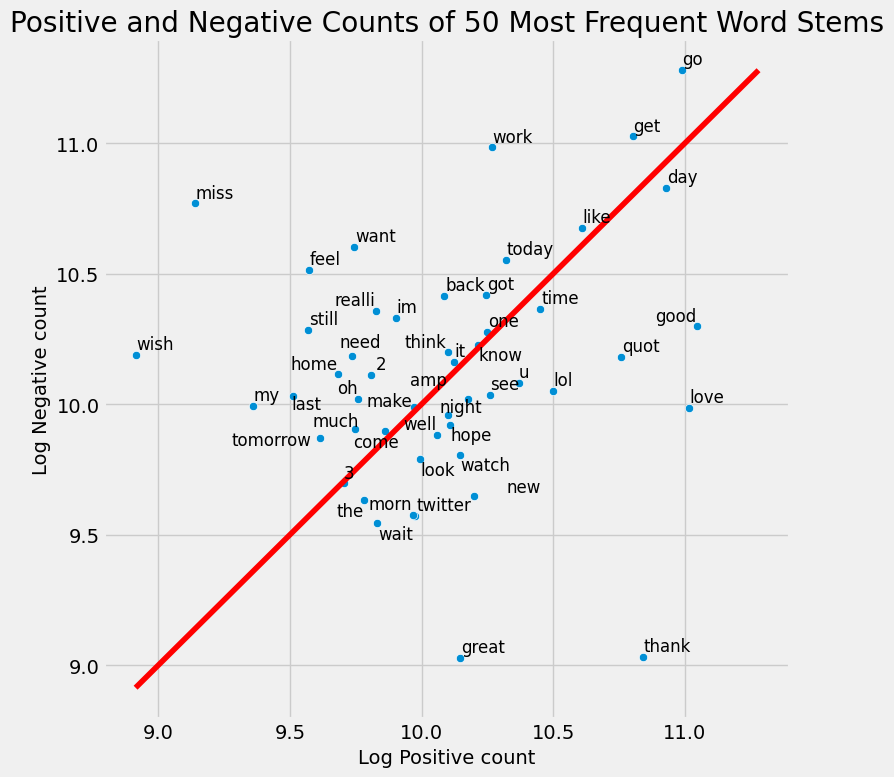

generating sentiment counts plot...9.21 seconds


In [31]:
@measure_time("generating sentiment counts plot")
def generate_sentiment_counts_plot(freqs_sorted, n=50):
    # GET UNIQUE LIST OF WORDS FROM KEYS IN FREQS_SORTED
    word_list = list(set(word for word, sentiment in freqs_sorted.keys()))

    # BUILD LIST OF WORDS WITH POSITIVE AND NEGATIVE SENTIMENT COUNTS
    data = [
        [word, freqs_sorted.get((word, 1), 0), freqs_sorted.get((word, 0), 0)]
        for word in word_list
        # Remove i since it is an outlier
        if word != "i"
    ]

    # SORT DATA BY THE SUM OF POSITIVE AND NEGATIVE COUNTS AND LIMIT TO TOP 'n' MOST FREQUENT WORDS
    data = sorted(data, key=lambda x: x[1] + x[2], reverse=True)[:n]

    # PREPARE X AND Y FOR PLOT, APPLY LOG TRANSFORMATION FOR LARGE COUNTS
    x = np.log([x[1] + 1 for x in data])
    y = np.log([x[2] + 1 for x in data])

    # CREATE SCATTER PLOT FOR LOG-TRANSFORMED COUNTS
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x, y=y)
    plt.title(f"Positive and Negative Counts of {n} Most Frequent Word Stems")
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # ADD ANNOTATIONS TO EACH POINT IN SCATTER PLOT, ADJUST TO AVOID OVERLAP
    texts = []
    for i in range(len(data)):
        texts.append(plt.text(x[i], y[i], data[i][0], fontsize=12))

    adjust_text(texts)

    # ADD RED LINE FROM MINIMUM TO MAXIMUM VALUE ON BOTH AXES
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    plt.plot([min_val, max_val], [min_val, max_val], color="red")

    # SAVE VISUALIZATION
    plt.tight_layout()
    plt.savefig("report/positive_and_negative_counts.png", dpi=300)

    plt.show()


# Call the function
generate_sentiment_counts_plot(freqs_sorted)

## Build & Evaluate Models

### Weights & Biases (`wandb`) Setup

We use Weights & Biases (wandb) for experiment tracking. This MLOps tool allows us to compare metrics from different runs and visualize model performance.

In [32]:
%%capture
wandb.login(key=os.getenv("WANDB_API_KEY"))

### Evaluation ###

In [33]:
def evaluateClassicalModel(classifier, xtest, ytest, class_labels, avg="macro", multiclass=False):
    with wandb.init(
        project="brand-sentiment-analysis",
        config={"model": classifier.model},
        name=f"{datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}_{classifier.model}",
    ) as run:
        # Make predictions
        predictions = classifier.model.predict(xtest)

        # Metrics - if classifier is multiclass, specify averaging method
        accuracy = accuracy_score(ytest, predictions)
        if multiclass:
            precision = precision_score(ytest, predictions, average=avg)
            recall = recall_score(ytest, predictions, average=avg)
            f1 = f1_score(ytest, predictions, average=avg)
        else:
            precision = precision_score(ytest, predictions)
            recall = recall_score(ytest, predictions)
            f1 = f1_score(ytest, predictions)

        candidate = (classifier, f1)
        if multiclass and candidate not in brand_classifiers:
            brand_classifiers.append(candidate)
        elif not multiclass and candidate not in sentiment_classifiers:
            sentiment_classifiers.append(candidate)

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1: {f1:.4f}")
        if multiclass:
            print(f"Metrics obtained using {avg} average")

        if multiclass:
            report = classification_report(
                ytest, predictions, target_names=class_labels, output_dict=True
            )

            report_df = pd.DataFrame(report).transpose()
            report_df.drop(["macro avg", "weighted avg", "accuracy"], inplace=True)
            report_df = report_df.reset_index().rename(columns={'index': 'class_name'})
            report_df = report_df.sort_values("f1-score", ascending=False).reset_index(drop=True)
            tbl = wandb.Table(data=report_df)
            display(report_df)
            
        
        # Construct confusion matrix
        cm = confusion_matrix(ytest, predictions)
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            cm, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

        if not multiclass:
            ytest = np.array(ytest)

        # Log to wandb
        wandb.log(
            {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "confusion_matrix": 
                wandb.plot.confusion_matrix(
                    probs=None, 
                    y_true=ytest, 
                    preds=predictions,
                    class_names=class_labels),
            }
        )
        
        if multiclass:
            wandb.log({"classification_report" : tbl})

        # Log model
        artifact = wandb.Artifact("model", type="model")
        joblib.dump(classifier.model, "model.pkl")
        artifact.add_file("model.pkl")
        run.log_artifact(artifact)
        os.remove("model.pkl")


In [35]:
brand_classifiers = []
sentiment_classifiers = []

## Brand Classifer


In [36]:
class BrandClassifier(ABC):
    
    def __init__(self, name, model, label_encoder):
        self.name = name
        self.model = model
        self.label_encoder = label_encoder

    @abstractmethod
    def vectorize(self, X):
        pass

    def predict(self, X):
        X_vectorized = self.vectorize(X)
        predictions = self.model.predict(X_vectorized)
        return self.label_encoder.inverse_transform(predictions)

In [37]:
class SimpleBrandClassifier(BrandClassifier):
    
    def __init__(self, name, model, vectorizer, label_encoder):
        super().__init__(name, model, label_encoder)
        self.vectorizer = vectorizer

    def vectorize(self, X):
        return self.vectorizer.transform(X)

### Multinomial Naive Bayes (`MultinomialNB`)

The Multinomial Naive Bayes classifier is a widely recognized and used tool in text classification. This classifier is based on Bayes' theorem, a principle in probability theory and statistics that describes the probability of an event based on prior knowledge of conditions that might be related to the event. The Multinomial Naive Bayes classifier assumes that all features, such as words in a tweet, are independent of each other. This is often called the 'naive' assumption, hence the name Naive Bayes.

This classifier is effective when dealing with features that are discrete counts. In text classification, this could be the number of times a specific word appears in a document or a tweet. The Multinomial Naive Bayes classifier requires these counts to be integers, aligning perfectly with word counts in text data. This makes the Multinomial Naive Bayes classifier an ideal choice for our text classification needs, as it can effectively handle and make predictions based on the vectorized text data.

### Linear Support Vector Classifier (`LinearSVC`)

The Linear Support Vector Classifier is a Support Vector Machine (SVM) often used for text classification tasks. SVMs are supervised learning methods for classification, regression, and outliers detection. The LinearSVC works by identifying the best boundary or 'hyperplane' that separates different data classes. This is achieved by maximizing the margin between the classes in the training data.

One of the strengths of LinearSVC is its ability to handle high-dimensional data. In text classification, once the text data is vectorized, it can result in a high-dimensional feature space, where each dimension corresponds to a unique word in the text.

### Logistic Regression

Logistic Regression is a statistical model used to predict the probability of a specific class or event. Despite its name, Logistic Regression is used for classification tasks, not regression tasks. In text classification, it's used to predict the likelihood of a specific word belonging to a particular category or class, such as whether a tweet mentions a brand.

Logistic Regression is known for its simplicity and efficiency. It uses a logistic function to model a binary dependent variable, making it a suitable choice for tasks where the output can be one of two possible outcomes. In our case, this could be whether a tweet mentions a brand or not.

### Multinomial Naive Bayes using count vectorizer ###

In [38]:
# Brand classification using Multinomial Naive Bayes using brand (name) as the target
X = brands_df.tweet
y = brands_df.brand

vectorizer = CountVectorizer()
label_encoder = LabelEncoder()

X_vectorized = vectorizer.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)

class_labels = label_encoder.classes_

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2)

multinomialNB_count_vectorizer = MultinomialNB()

multinomialNB_count_vectorizer.fit(X_train, y_train)

mnb_classifier = SimpleBrandClassifier(
    'multinomialNB_count_vectorizer',
    multinomialNB_count_vectorizer,
    vectorizer,
    label_encoder
)


Accuracy: 0.8264
Precision: 0.9287
Recall: 0.6939
F1: 0.7791
Metrics obtained using macro average


,class_name,precision,recall,f1-score,support
0,facebook,0.885431,0.889205,0.887314,704.0
1,google,0.892405,0.870370,0.881250,486.0
2,nobrand,0.747273,0.945740,0.834874,2101.0
3,apple,0.884021,0.790323,0.834550,434.0
4,sony,0.975610,0.661157,0.788177,121.0
5,amazon,0.988764,0.637681,0.775330,138.0
6,disney,0.977654,0.641026,0.774336,273.0
7,starbucks,0.949495,0.620462,0.750499,303.0
8,walmart,0.977528,0.568627,0.719008,153.0
9,target,0.988235,0.541935,0.700000,155.0


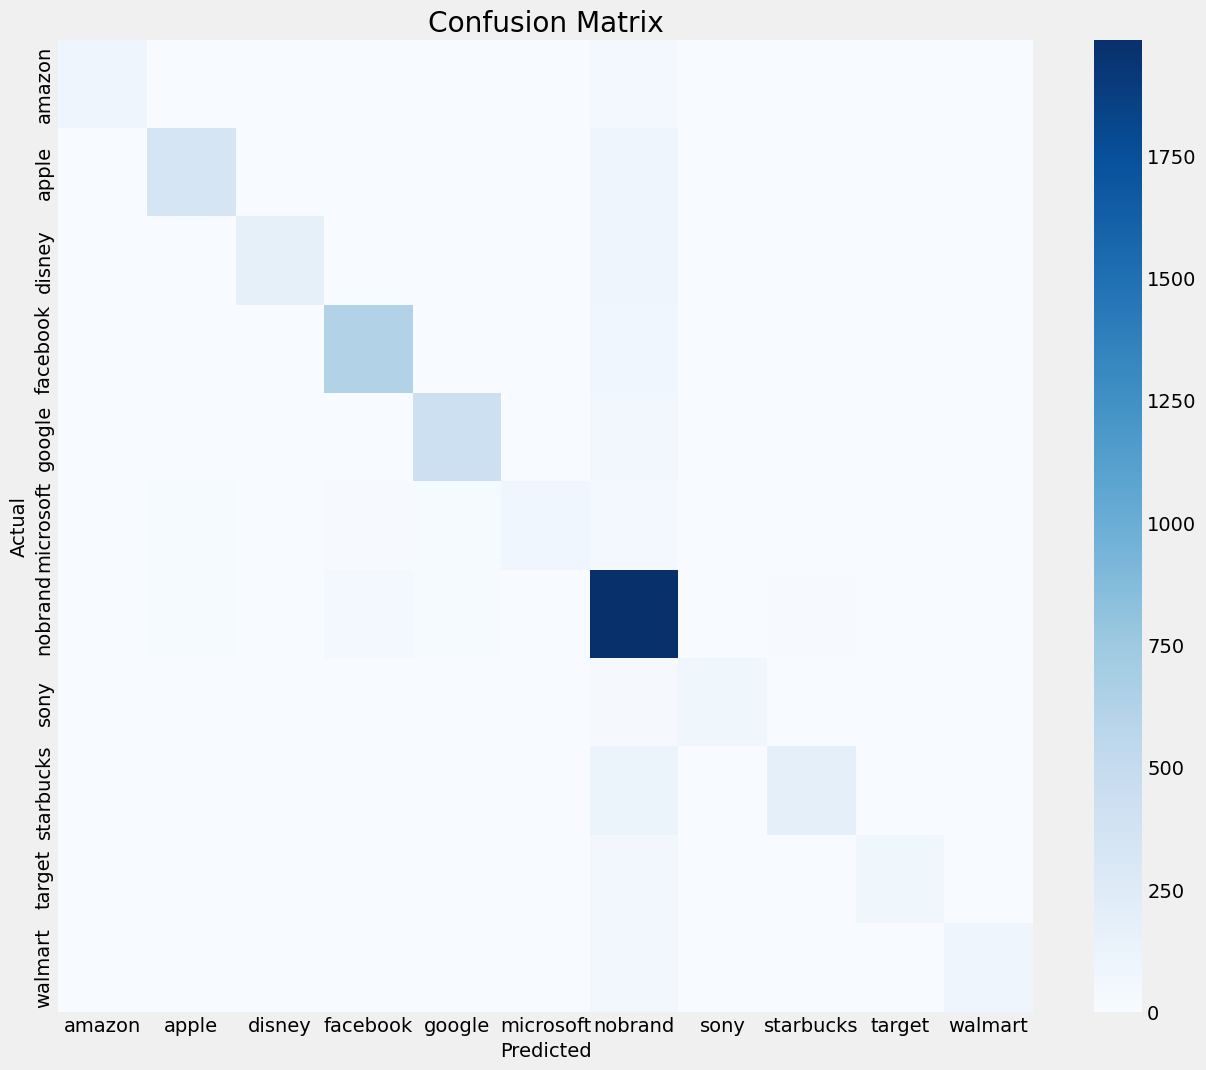

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.82641
f1,0.77912
precision,0.92871
recall,0.69385


In [39]:
evaluateClassicalModel(
    mnb_classifier, 
    X_test, 
    y_test, 
    class_labels, 
    multiclass=True
)

In [40]:
# Quick test
new_tweets = [
    "apple is the best company",
    "I love apples",
    "Apples are the worst",
    "I like apple?",
]

new_tweets_vectorized = vectorizer.transform(new_tweets)
test_prediction = multinomialNB_count_vectorizer.predict(new_tweets_vectorized)
new_predicted_brand_name = label_encoder.inverse_transform(test_prediction)

for tweet, prediction in zip(new_tweets, new_predicted_brand_name):
    print(f"Test tweet: {tweet} -> predicted class: {prediction}")

Test tweet: apple is the best company -> predicted class: apple
Test tweet: I love apples -> predicted class: nobrand
Test tweet: Apples are the worst -> predicted class: apple
Test tweet: I like apple? -> predicted class: apple


### LinearSVC using count vectorizer

In [41]:
X = brands_df.tweet
y = brands_df.brand

vectorizer = CountVectorizer()
label_encoder = LabelEncoder()

X_vectorized = vectorizer.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)

class_labels = label_encoder.classes_

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2)

svc_count_vectorizer = LinearSVC()
svc_count_vectorizer.fit(X_train, y_train)

svc_classifier = SimpleBrandClassifier(
    'svc_count_vectorizer',
    svc_count_vectorizer,
    vectorizer,
    label_encoder
)

Accuracy: 0.9968
Precision: 0.9966
Recall: 0.9961
F1: 0.9963
Metrics obtained using macro average


,class_name,precision,recall,f1-score,support
0,amazon,1.000000,1.000000,1.000000,142.0
1,walmart,1.000000,1.000000,1.000000,159.0
2,starbucks,0.996466,1.000000,0.998230,282.0
3,facebook,0.997046,0.998521,0.997783,676.0
4,nobrand,0.997637,0.997637,0.997637,2116.0
5,target,1.000000,0.993631,0.996805,157.0
6,disney,0.993289,1.000000,0.996633,296.0
7,sony,1.000000,0.993007,0.996491,143.0
8,google,0.993151,0.997706,0.995423,436.0
9,apple,0.997849,0.989339,0.993576,469.0


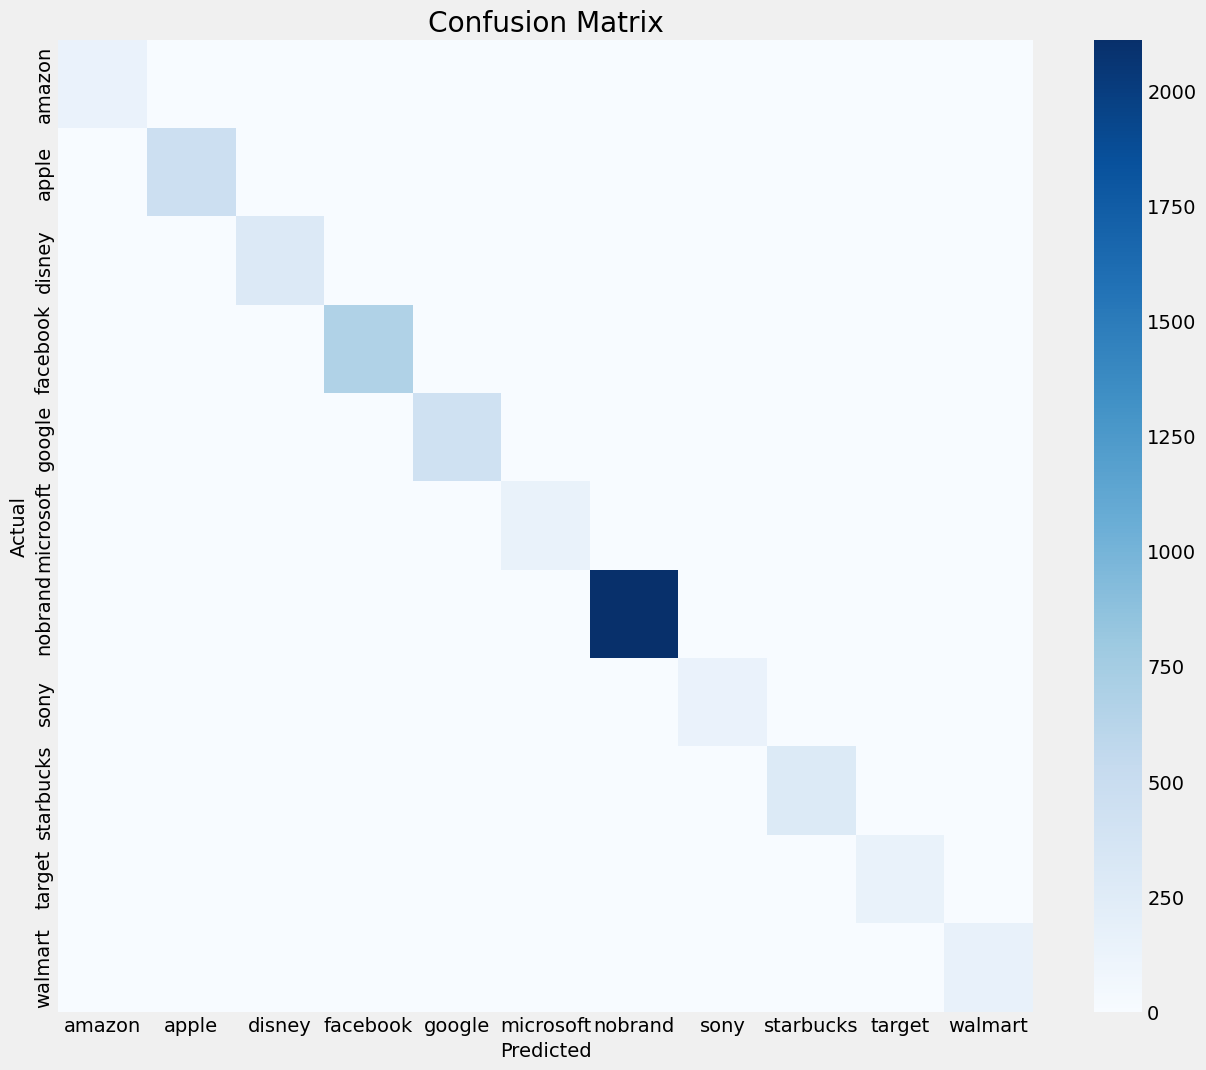

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.99682
f1,0.99632
precision,0.99658
recall,0.99607


In [42]:
evaluateClassicalModel(
    svc_classifier, 
    X_test, 
    y_test, 
    class_labels, 
    multiclass=True
)

### Logistic Regression using word2vec vector embedding ###

In [43]:
class Word2VecBrandClassifier(BrandClassifier):
    
    def __init__(self, name, model, word2vec_model, label_encoder):
        super().__init__(name, model, label_encoder)
        self.word2vec_model = word2vec_model

    def vectorize(self, X):
        return np.array([compute_mean_word2vec_vector(self.word2vec_model, x) for x in X])

In [44]:
brands_df_processed = brands_df.copy()
brands_df_processed = apply_preprocessing(brands_df_processed)

# Logistic regression using vector embeddings with Word2Vec
# vector_size: dimensionality of the word vectors
# window: maximum distance between a target word and words around the target word
# (smaller windows tend to capture more syntactic information, larger windows more semantic information)
# min_count: minimum number of occurrences of a word in the corpus to include it in the model
# workers: number of threads used to train the model
# sg: training algorithm (0 is continuous bag of words)
vector_size = 100
word2vec_model = Word2Vec(
    brands_df_processed.processed_text,
    vector_size=vector_size,
    window=5,
    min_count=1,
    workers=4,
    sg=0,
)

def compute_mean_word2vec_vector(word2vec_model, words):
    word_vectors = [
        word2vec_model.wv[word] for word in words if word in word2vec_model.wv
    ]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

brands_df_processed["word2vec_vector"] = brands_df_processed.processed_text.apply(
    lambda x: compute_mean_word2vec_vector(word2vec_model, x)
)

label_encoder = LabelEncoder()

x = np.vstack(brands_df_processed["word2vec_vector"].values)
y = label_encoder.fit_transform(brands_df_processed["brand"])

class_labels = label_encoder.classes_

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

logisticRegression_word2vec = LogisticRegression(max_iter=1000)
logisticRegression_word2vec.fit(xtrain, ytrain)

preprocessing training data...2.52 seconds


LogisticRegression(max_iter=1000)

In [45]:
lrw2v_classifier = Word2VecBrandClassifier(
    'logisticRegression_word2vec',
    logisticRegression_word2vec,
    word2vec_model,
    label_encoder
)

Accuracy: 0.8753
Precision: 0.8832
Recall: 0.7408
F1: 0.7972
Metrics obtained using macro average


,class_name,precision,recall,f1-score,support
0,apple,0.964206,0.970721,0.967452,444.0
1,facebook,0.949527,0.921899,0.935509,653.0
2,google,0.955414,0.912779,0.933610,493.0
3,disney,0.949791,0.890196,0.919028,255.0
4,nobrand,0.822347,0.967376,0.888985,2115.0
5,starbucks,0.926531,0.737013,0.820976,308.0
6,microsoft,0.900901,0.625000,0.738007,160.0
7,amazon,0.828571,0.561290,0.669231,155.0
8,sony,0.860465,0.544118,0.666667,136.0
9,target,0.774775,0.551282,0.644195,156.0


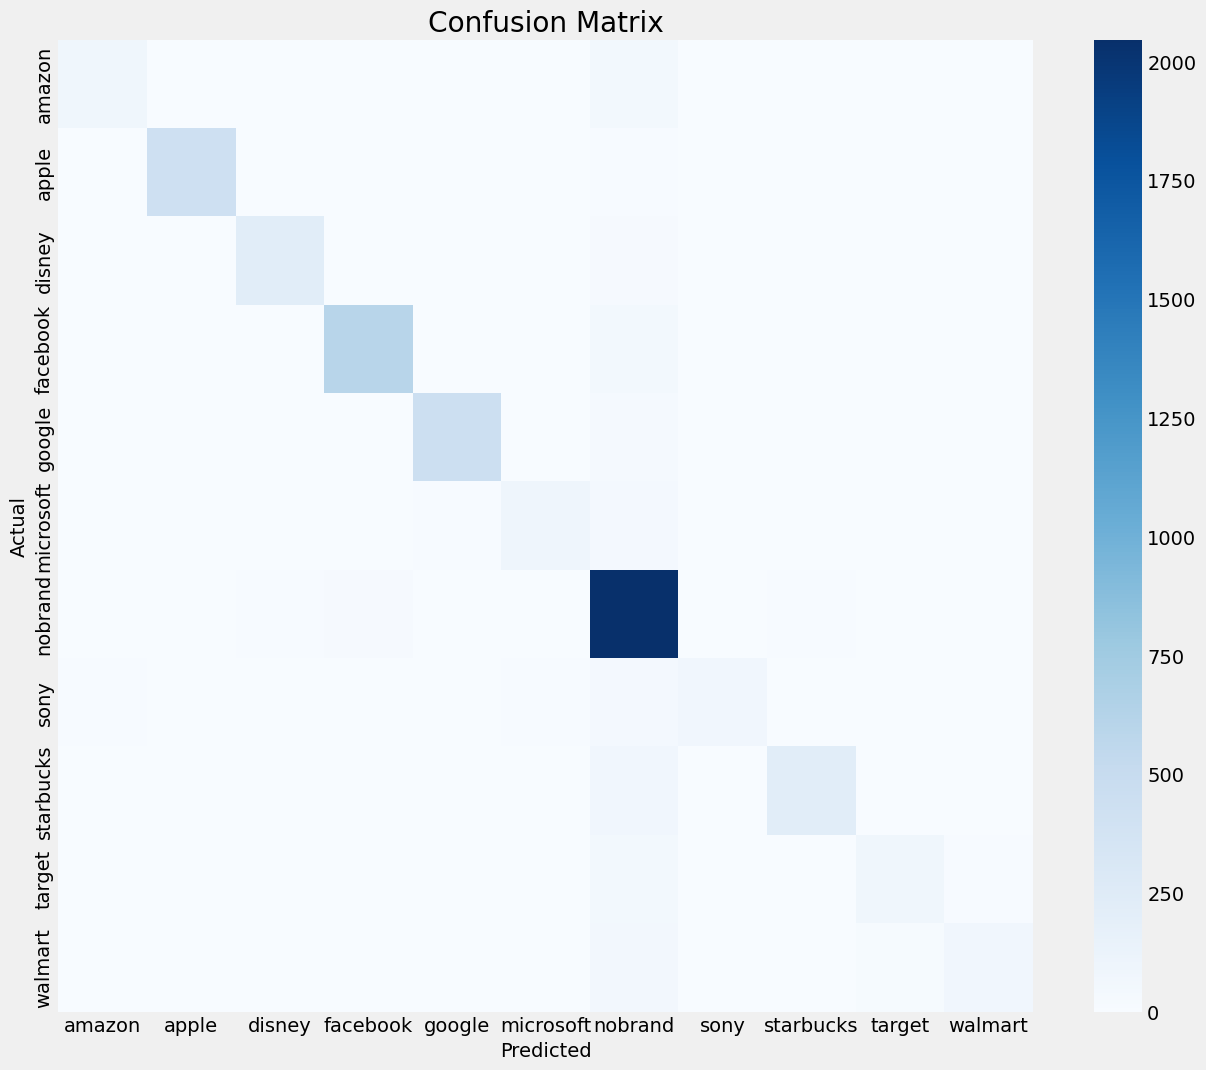

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.87532
f1,0.79718
precision,0.88319
recall,0.74084


In [46]:
evaluateClassicalModel(
    lrw2v_classifier, 
    xtest, 
    ytest, 
    class_labels, 
    multiclass=True
)

In [96]:
sorted_brand_classifiers = sorted(brand_classifiers, key=lambda x: x[1], reverse=True)
print(sorted_brand_classifiers)

[(<__main__.SimpleBrandClassifier object at 0x000002326C7BF220>, 0.9937731753143357), (<__main__.SimpleBrandClassifier object at 0x000002323EF5A7D0>, 0.7927436180017584), (<__main__.Word2VecBrandClassifier object at 0x000002326B91A950>, 0.7868326064059009)]


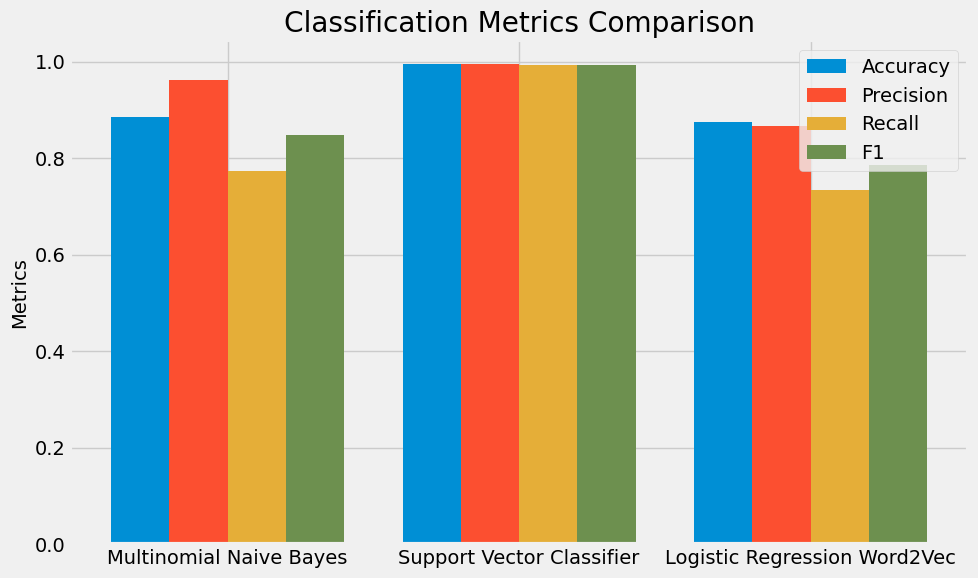

In [47]:
# Metrics data
approaches = ['Multinomial Naive Bayes', 'Support Vector Classifier', 'Logistic Regression Word2Vec']
accuracy = [0.8861, 0.9948, 0.8747]
precision = [0.9624, 0.9946, 0.8679]
recall = [0.7734, 0.9930, 0.7334]
f1 = [0.8482, 0.9938, 0.7868]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(approaches))
width = 0.2

ax.bar(x, accuracy, width, label='Accuracy')
ax.bar([i + width for i in x], precision, width, label='Precision')
ax.bar([i + width * 2 for i in x], recall, width, label='Recall')
ax.bar([i + width * 3 for i in x], f1, width, label='F1')

ax.set_xticks([i + width * 1.5 for i in x])
ax.set_xticklabels(approaches)
ax.set_ylabel('Metrics')
ax.set_title('Classification Metrics Comparison')
ax.legend()

plt.tight_layout()
plt.show()

## Sentiment Classifier

In [48]:
class SentimentClassifier(ABC):
    
    @abstractmethod
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    @abstractmethod
    def vectorize(self, X):
        pass
    
    def predict(self, X):
        X_vectorized = self.vectorize(X)
        return self.model.predict(X_vectorized)

### Logistic Regression using tdidf vectorizer

In [49]:
class TFIDFSentimentClassifier(SentimentClassifier):

    def __init__(self, name, model, vectorizer):
        super().__init__(name, model)
        self.vectorizer = vectorizer

    def vectorize(self, X):
        return self.vectorizer.transform(X)

In [50]:
x = tweets_df.tweet
y = tweets_df.sentiment

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
lr_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
lr_vectorizer.fit(xtrain)

xtrain = lr_vectorizer.transform(xtrain)
xtest = lr_vectorizer.transform(xtest)

logisticRegression_tfidf = LogisticRegression()
logisticRegression_tfidf.fit(xtrain, ytrain)


LogisticRegression()

In [51]:
tfidf_classifier = TFIDFSentimentClassifier(
    'logisticRegression_tfidf',
    logisticRegression_tfidf,
    lr_vectorizer
)

Accuracy: 0.8230
Precision: 0.8185
Recall: 0.8309
F1: 0.8247


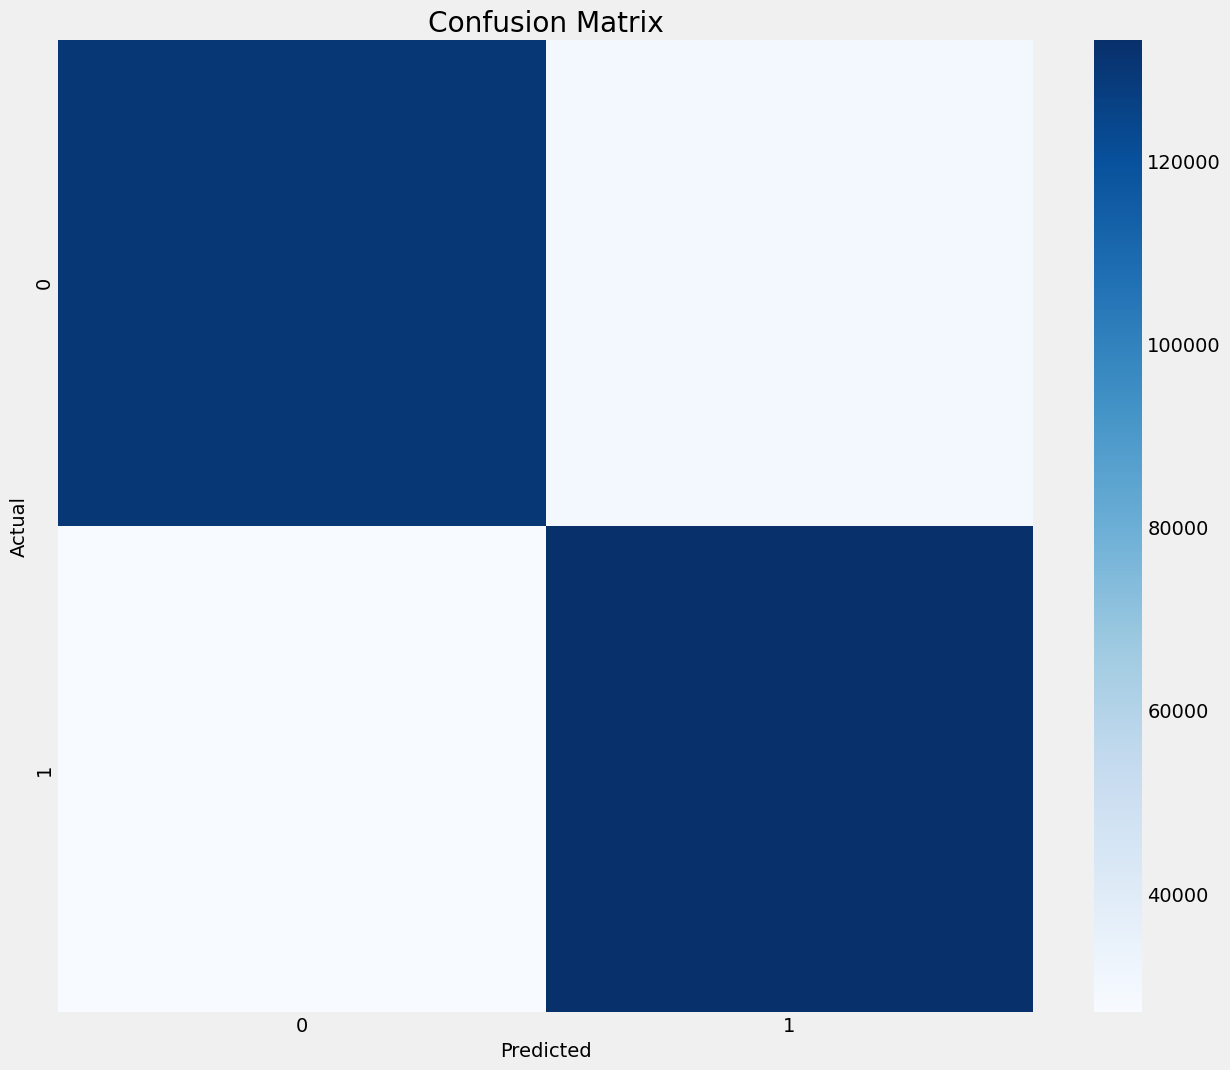

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.823
f1,0.82465
precision,0.81846
recall,0.83094


In [52]:
evaluateClassicalModel(
    tfidf_classifier,
    xtest, 
    ytest, 
    class_labels=[0, 1]
)

### Logistic Regression using doc2vec vector embedding

In [53]:
class Doc2VecSentimentClassifier(SentimentClassifier):

    def __init__(self, name, model, d2v_model):
        super().__init__(name, model)
        self.d2v_model = d2v_model

    def vectorize(self, texts):
        return np.vstack([self.d2v_model.infer_vector(text.split()) for text in texts])

In [54]:
tweets_df_copy = tweets_df.copy()

In [56]:
# Define hyperparameters
vector_size = 100
window = 5
min_count = 1
workers = multiprocessing.cpu_count()
epochs = 10

tagged_documents = [
    TaggedDocument(words=words, tags=[i])
    for i, words in enumerate(tweets_df_copy.processed_text)
]

# Train the model and log metrics
doc2vec_model = Doc2Vec(
    documents=None,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=0,
)

doc2vec_model.build_vocab(tagged_documents)

for epoch in range(epochs):
    print("Starting epoch...")
    start_time = time.time()
    doc2vec_model.train(
        tagged_documents,
        total_examples=doc2vec_model.corpus_count,
        epochs=1,
    )
    end_time = time.time()
    elapsed_time = end_time - start_time


Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...


In [58]:
tweets_df_copy["doc2vec_vector"] = tweets_df_copy.processed_text.apply(
    lambda x: doc2vec_model.infer_vector(x)
)

In [59]:
x = np.vstack(tweets_df_copy["doc2vec_vector"].values)
y = tweets_df_copy["sentiment"]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

logisticRegression_doc2vec = LogisticRegression()
logisticRegression_doc2vec.fit(xtrain, ytrain)

LogisticRegression()

In [60]:
doc2vec_classifier = Doc2VecSentimentClassifier(
    'logisticRegression_doc2vec',
    logisticRegression_doc2vec,
    doc2vec_model
)

Accuracy: 0.6604
Precision: 0.6514
Recall: 0.6930
F1: 0.6716


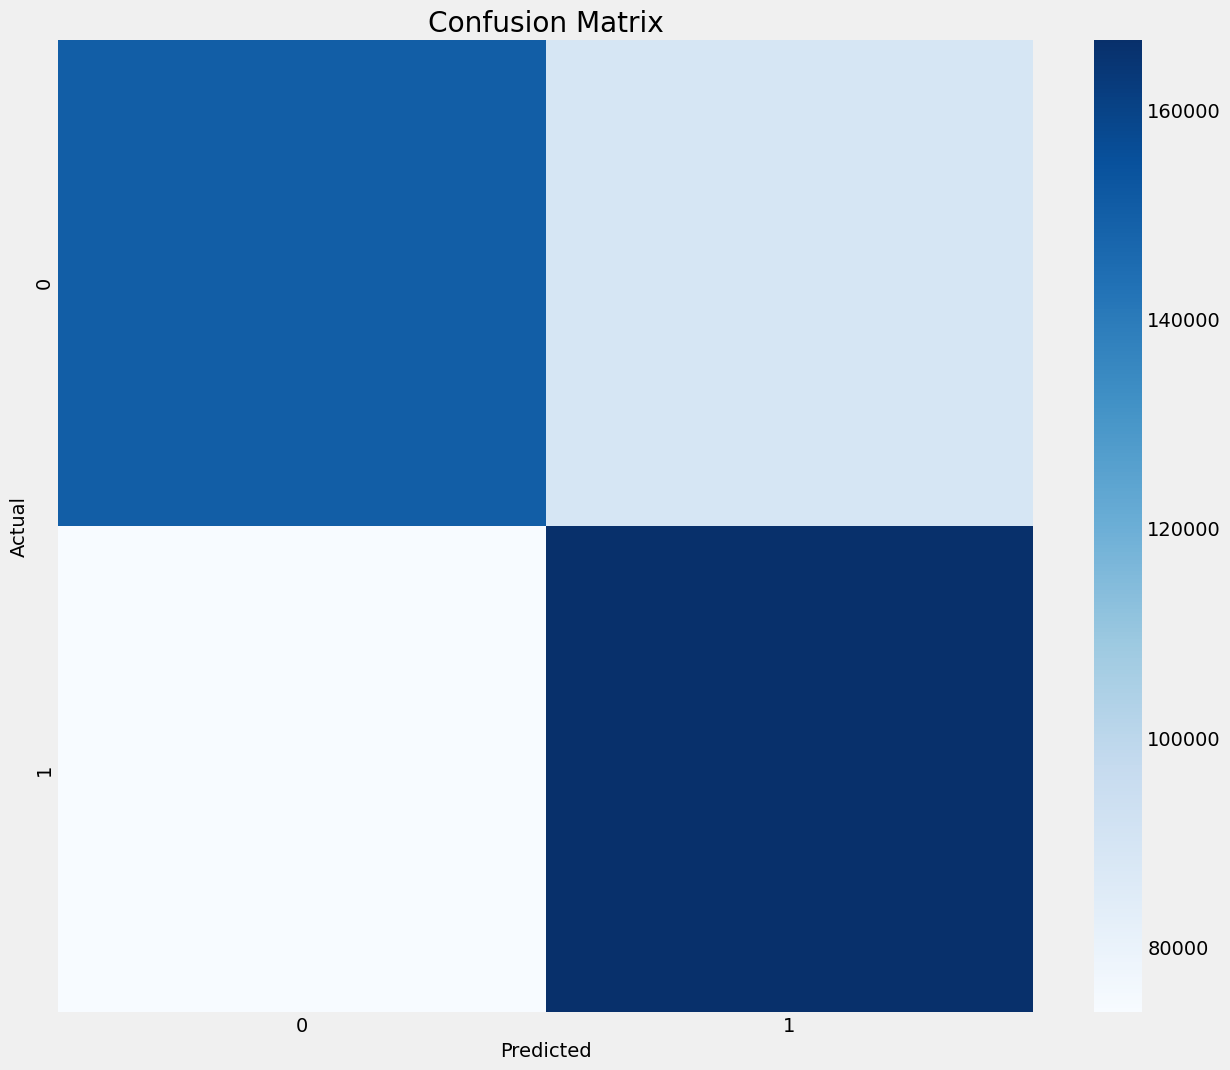

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.66035
f1,0.67156
precision,0.65139
recall,0.69302


In [61]:
evaluateClassicalModel(
    doc2vec_classifier,
    xtest, 
    ytest, 
    class_labels=[0, 1]
)

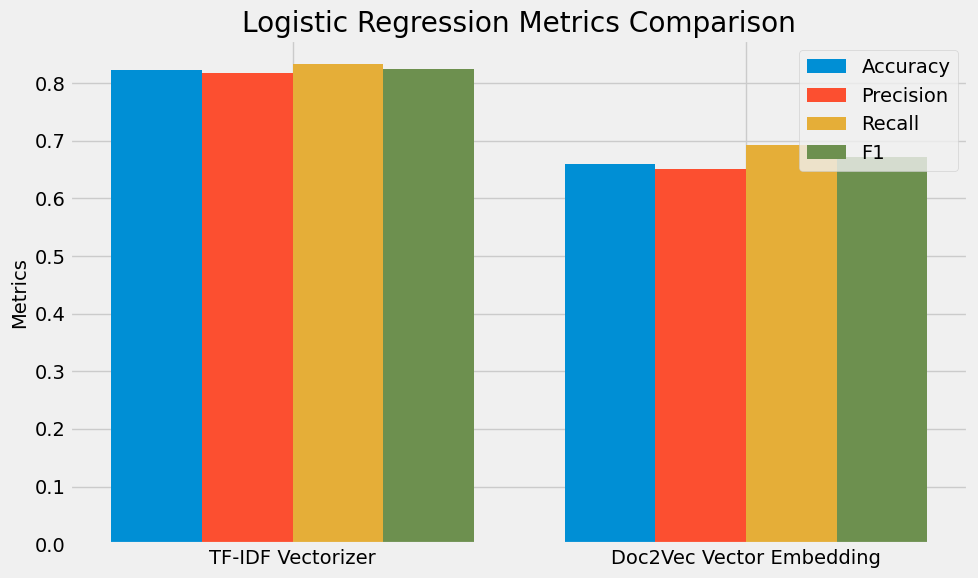

In [62]:
# Metrics data
approaches = ['TF-IDF Vectorizer', 'Doc2Vec Vector Embedding']
accuracy = [0.8229, 0.6598]
precision = [0.8172, 0.6507]
recall = [0.8328, 0.6928]
f1 = [0.8249, 0.6711]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(approaches))
width = 0.2

ax.bar(x, accuracy, width, label='Accuracy')
ax.bar([i + width for i in x], precision, width, label='Precision')
ax.bar([i + width * 2 for i in x], recall, width, label='Recall')
ax.bar([i + width * 3 for i in x], f1, width, label='F1')

ax.set_xticks([i + width * 1.5 for i in x])
ax.set_xticklabels(approaches)
ax.set_ylabel('Metrics')
ax.set_title('Logistic Regression Metrics Comparison')
ax.legend()

plt.tight_layout()
plt.show()


### Logistic Regression using Universal Sentence Encoder

In [70]:
# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [71]:
tweets_df_copy = tweets_df.copy()

# Generate embeddings
embeddings = tweets_df_copy.tweet.apply(lambda x: embed([x]).numpy()[0])

# Convert the embeddings to a numpy array
x = np.array([embedding for embedding in embeddings])
y = tweets_df_copy["sentiment"]

# Split the data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

logisticRegression_use = LogisticRegression()
logisticRegression_use.fit(xtrain, ytrain)

KeyboardInterrupt: 

In [ ]:
evaluateClassicalModel(
    'logisticRegression_doc2vec', 
    logisticRegression_doc2vec,
    xtest, 
    ytest, 
    class_labels=[0, 1]
)

TypeError: evaluateClassicalModel() got multiple values for argument 'class_labels'

In [ ]:
sorted_sentiment_classifiers = sorted(sentiment_classifiers, key=lambda x: x[1], reverse=True)
print(sorted_sentiment_classifiers)

[(<__main__.TFIDFSentimentClassifier object at 0x0000023254DF64D0>, 0.8260453417668979), (<__main__.Doc2VecSentimentClassifier object at 0x00000231C75C8280>, 0.6710921969817507)]


## Putting It All Together - Brand Sentiment Analyzer ##


In [ ]:
# Choose the brand and sentiment classifier with the highest score
print(f"Brand classifier: {sorted_brand_classifiers[0][0].name}")
brand_classifier = sorted_brand_classifiers[0][0]

print(f"Sentiment classifier: {sorted_sentiment_classifiers[0][0].name}")
sentiment_classifier = sorted_sentiment_classifiers[0][0]

Brand classifier: svc_count_vectorizer
Sentiment classifier: logisticRegression_tfidf


In [ ]:
class BrandSentimentAnalyzer:
    def __init__(self, brand_classifier, sentiment_classifier):
        self.brand_classifier = brand_classifier
        self.sentiment_classifier = sentiment_classifier

    def predict(self, tweets):
        brand_predictions = self.brand_classifier.predict(tweets)
        sentiment_predictions = self.sentiment_classifier.predict(tweets)
        
        return list(zip(brand_predictions, sentiment_predictions))


In [105]:
analyzer = BrandSentimentAnalyzer(brand_classifier, sentiment_classifier)
tweets = [
    "Wow I was just at starbucks and the employees were so friendly", 
    "I'm not so sure how I feel about target", 
    "I went grocery shopping yesterday"
    ]
results = analyzer.predict(tweets)
print(results)

[('starbucks', 0), ('target', 0), ('nobrand', 1)]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ground truth labels for brand and sentiment for each tweet
true_brand_labels = ["Starbucks", "Target", "Other"]
true_sentiment_labels = ["Positive", "Neutral", "Negative"]

# Predicted labels from the BrandSentimentAnalyzer
predicted_brand_labels, predicted_sentiment_labels = zip(*results)

# Evaluate brand classification metrics
brand_accuracy = accuracy_score(true_brand_labels, predicted_brand_labels)
brand_precision = precision_score(true_brand_labels, predicted_brand_labels, average='weighted')
brand_recall = recall_score(true_brand_labels, predicted_brand_labels, average='weighted')
brand_f1 = f1_score(true_brand_labels, predicted_brand_labels, average='weighted')

# Evaluate sentiment classification metrics
sentiment_accuracy = accuracy_score(true_sentiment_labels, predicted_sentiment_labels)
sentiment_precision = precision_score(true_sentiment_labels, predicted_sentiment_labels, average='weighted')
sentiment_recall = recall_score(true_sentiment_labels, predicted_sentiment_labels, average='weighted')
sentiment_f1 = f1_score(true_sentiment_labels, predicted_sentiment_labels, average='weighted')

# Print evaluation results
print("Brand Classification Metrics:")
print(f"Accuracy: {brand_accuracy:.2f}")
print(f"Precision: {brand_precision:.2f}")
print(f"Recall: {brand_recall:.2f}")
print(f"F1-Score: {brand_f1:.2f}")
print()

print("Sentiment Classification Metrics:")
print(f"Accuracy: {sentiment_accuracy:.2f}")
print(f"Precision: {sentiment_precision:.2f}")
print(f"Recall: {sentiment_recall:.2f}")
print(f"F1-Score: {sentiment_f1:.2f}")



# Make sure to replace the class labels and ground truth values (true_brand_labels and true_sentiment_labels) with the actual data you have. 
# This code calculates precision, recall, and F1-score using the 'weighted' averaging strategy, which provides a balanced metric when dealing with imbalanced class distributions. 
# You can adjust the averaging strategy based on your needs (e.g., 'micro', 'macro', etc.).
# Also, ensure that the predicted labels (predicted_brand_labels and predicted_sentiment_labels) are obtained correctly from your BrandSentimentAnalyzer.

In [ ]:
# PRINT METRICS
metrics.print_metrics()

Metrics:
  generating word cloud from training data: 16.23 seconds
  generating sentiment counts plot: 8.97 seconds
  creating brands dataframe: 5.47 seconds
  loading preprocessed data: 3.02 seconds
  getting word sentiment frequencies: 2.30 seconds
  preprocessing training data: 2.12 seconds
  printing sample preprocessed text: 0.04 seconds
Total time: 38.15 seconds
